# Introduction

**X Education**, a prominent e-learning platform, is grappling with the challenge of optimizing its lead-to-customer conversion rate. Despite a current conversion rate of 30%, there exists an opportunity to enhance this metric. 

Through this analysis, we intend to devise a logistic regression model to assign a lead score to each potential customer, indicating their conversion probability. The target audience for these findings is the X Education marketing and sales teams.  

This systematic prioritization of higher scoring 'Hot Leads' will empower X Education to refine allocation of sales resources. Our goal is to provide data-driven insights that ultimately improve conversion rates closer to the aspirational 80% goal.

**Objective:** Develop a predictive lead scoring model to identify high conversion probability leads, and deliver actionable insights to sales/marketing teams on refining the lead conversion mechanism.

# Libraries 

In [1]:
# Data manipulation and analysis
import pandas as pd  # Dataframe operations
import numpy as np  # Array and matrix operations
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy import stats
from itertools import combinations
from math import comb


# Data visualization
import matplotlib.pyplot as plt  # Base plotting library
import seaborn as sns  # Advanced plotting
sns.set_style("whitegrid")  # Background grid style for seaborn plots

# Pretty table display
from tabulate import tabulate

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


# Loading Data

In [2]:
# Import lead information from the CSV file
df = pd.read_csv("Leads.csv")

# Retrieve column descriptions from the data dictionary
data_dictionary = pd.read_excel("Leads Data Dictionary.xlsx")

# Raw data exploration

In [3]:
#  General Info of data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [4]:
# Displaying the shape of the loaded dataframes
print("Leads Dataset Shape:", df.shape)
print("Data Dictionary Shape:", data_dictionary.shape)

# Displaying the top rows of the datasets for a quick glance
print("\nLeads Dataset Preview:")
display(df.head())

print("\nData Dictionary Preview:")
display(data_dictionary.head())

Leads Dataset Shape: (9240, 37)
Data Dictionary Shape: (37, 2)

Leads Dataset Preview:


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified



Data Dictionary Preview:


,Variables,Description
0,Prospect ID,A unique ID with which the customer is identified.
1,Lead Number,A lead number assigned to each lead procured.
2,Lead Origin,"The origin identifier with which the customer was identified to be a lead. Includes API, Landing Page Submission, etc."
3,Lead Source,"The source of the lead. Includes Google, Organic Search, Olark Chat, etc."
4,Do Not Email,An indicator variable selected by the customer wherein they select whether of not they want to be emailed about the course or not.


# Data Preprocessing

#### Updating Data Dictionary

- During the initial exploration of the `data_dictionary`, we identified that several variables shared a common description, leading to NaN values for subsequent variables with the same description. To ensure clarity and completeness of our data dictionary, we decided to manually map these shared descriptions to their respective variables.


In [5]:
# Mapping shared descriptions to respective variables for clarity
description_mapping = {
    'Search': 'Indicating whether the customer saw the ad in any of the listed items.',
    'Magazine': 'Indicating whether the customer saw the ad in any of the listed items.',
    'Newspaper Article': 'Indicating whether the customer saw the ad in any of the listed items.',
    'X Education Forums': 'Indicating whether the customer saw the ad in any of the listed items.',
    'Newspaper': 'Indicating whether the customer saw the ad in any of the listed items.',
    'Digital Advertisement': 'Indicating whether the customer saw the ad in any of the listed items.',
    'Asymmetrique Activity Index': 'Index and score based on customer activity and profile',
    'Asymmetrique Profile Index': 'Index and score based on customer activity and profile',
    'Asymmetrique Activity Score': 'Index and score based on customer activity and profile',
    'Asymmetrique Profile Score': 'Index and score based on customer activity and profile'
}

# Applying the mapping to the Data Dictionary
data_dictionary['Description'] = data_dictionary['Variables'].map(description_mapping).fillna(data_dictionary['Description'])


#### Column Consistency Check Between `df` and `data_dictionary`

- To ensure clarity and consistency in our analysis, verifying the alignment of column names in the `df` with the variable names in the `data_dictionary` is crucial. Discrepancies might indicate mismatches or areas that require attention. We'll systematically identify these differences.


In [6]:
# Extracting columns from df and variables from data_dictionary
leads_columns = set(df.columns)
data_dict_variables = set(data_dictionary['Variables'])

# Identifying discrepancies between the two sets
missing_in_data_dict = leads_columns - data_dict_variables
extra_in_data_dict = data_dict_variables - leads_columns

print("Columns in `df` absent in `data_dictionary`:", missing_in_data_dict)
print("\nVariables in `data_dictionary` absent in `df`:", extra_in_data_dict)


Columns in `df` absent in `data_dictionary`: {'What matters most to you in choosing a course', 'A free copy of Mastering The Interview'}

Variables in `data_dictionary` absent in `df`: {'What matters most to you in choosing this course', 'a free copy of Mastering The Interview'}


#### Aligning Variable Names for Consistency

- The discrepancies between the `df` column names and the `data_dictionary` variable names have been identified. To maintain consistency and clarity throughout our analysis, we'll update the `data_dictionary` to match the column names present in the `df` dataframe.

In [7]:
# Adjusting the mismatched values in the Variables column of data_dictionary
data_dictionary['Variables'].replace({
    'What matters most to you in choosing this course': 'What matters most to you in choosing a course',
    'a free copy of Mastering The Interview': 'A free copy of Mastering The Interview'
}, inplace=True)

# Verifying the alignment post corrections
updated_data_dict_variables = set(data_dictionary['Variables'])
missing_in_data_dict_updated = leads_columns - updated_data_dict_variables
extra_in_data_dict_updated = updated_data_dict_variables - leads_columns

print("Columns in `df` absent in updated `data_dictionary`:", missing_in_data_dict_updated)
print("\nVariables in updated `data_dictionary` absent in `df`:", extra_in_data_dict_updated)


Columns in `df` absent in updated `data_dictionary`: set()

Variables in updated `data_dictionary` absent in `df`: set()


#### Refactoring Column Names:

-  Extensive column names in the df dataframe can complicate data manipulation and analysis.
-  Refactoring these names will streamline the workflow and enhance code readability.

In [8]:
# Dictionary to map original column names to concise names
column_mapping = {
    'Prospect ID': 'ProspectID',
    'Lead Number': 'LeadNum',
    'Lead Origin': 'Origin',
    'Lead Source': 'Source',
    'Do Not Email': 'DontEmail',
    'Do Not Call': 'DontCall',
    'Total Time Spent on Website': 'WebsiteTime',
    'Page Views Per Visit': 'AvgPageViews',
    'Last Activity': 'LastAct',
    'How did you hear about X Education': 'Referral',
    'What is your current occupation': 'Occupation',
    'What matters most to you in choosing a course': 'CoursePref',
    'Search': 'OnlineSearch',
    'Magazine': 'MagazineSub',
    'Newspaper Article': 'NewsArticle',
    'X Education Forums': 'ForumVisit',
    'Newspaper': 'ReadNews',
    'Digital Advertisement': 'DigitalAd',
    'Through Recommendations': 'Recommended',
    'Receive More Updates About Our Courses': 'WantsUpdates',
    'Update me on Supply Chain Content': 'SupplyChainInfo',
    'Get updates on DM Content': 'DMInfo',
    'Lead Profile': 'Profile',
    'City': 'City',
    'Asymmetrique Activity Index': 'ActIndex',
    'Asymmetrique Profile Index': 'ProfIndex',
    'Asymmetrique Activity Score': 'ActScore',
    'Asymmetrique Profile Score': 'ProfScore',
    'I agree to pay the amount through cheque': 'PayByCheque',
    'A free copy of Mastering The Interview': 'InterviewCopy',
    'Last Notable Activity': 'LastMajorAct'
}

# Applying column name changes to the df dataframe
df.rename(columns=column_mapping, inplace=True)

# Displaying updated column names in df for verification
print("Updated Columns in `df`:\n", df.columns)

# Aligning variable names in the data_dictionary with the updated column names
data_dictionary['Variables'] = data_dictionary['Variables'].map(column_mapping).fillna(data_dictionary['Variables'])

# Displaying updated variable names in data_dictionary for verification
print("\nUpdated Variables in `data_dictionary`:\n", data_dictionary['Variables'].unique())


Updated Columns in `df`:
 Index(['ProspectID', 'LeadNum', 'Origin', 'Source', 'DontEmail', 'DontCall',
       'Converted', 'TotalVisits', 'WebsiteTime', 'AvgPageViews', 'LastAct',
       'Country', 'Specialization', 'Referral', 'Occupation', 'CoursePref',
       'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews',
       'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'Lead Quality',
       'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'ActIndex', 'ProfIndex',
       'ActScore', 'ProfScore', 'PayByCheque', 'InterviewCopy',
       'LastMajorAct'],
      dtype='object')

Updated Variables in `data_dictionary`:
 ['ProspectID' 'LeadNum' 'Origin' 'Source' 'DontEmail' 'DontCall'
 'Converted' 'TotalVisits' 'WebsiteTime' 'AvgPageViews' 'LastAct'
 'Country' 'Specialization' 'Referral' 'Occupation' 'CoursePref'
 'OnlineSearch' 'MagazineSub' 'NewsArticle' 'ForumVisit' 'ReadNews'
 'DigitalAd' 'Recommended' 'WantsUpdates' 'Tags' 'Lead Quality'
 'SupplyChainInfo' 'DMInfo' 'P

In [9]:
# Displaying the updated data dictionary
data_dictionary.sort_values(by="Variables", inplace=True)
data_dictionary.reset_index(drop=True, inplace=True)

In [10]:
print(tabulate(data_dictionary, headers='keys', tablefmt='psql'))

+----+-----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | Variables       | Description                                                                                                                                                                       |
|----+-----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | ActIndex        | Index and score based on customer activity and profile                                                                                                                            |
|  1 | ActScore        | Index and score based on customer activity and profile                                                                                                     

In [11]:
#  Saving new datframe to csv 
df.to_csv('New_df.csv', index=False)
data_dictionary.to_csv('New_data_dictionary.csv', index=False)

#  Analysis 

## Initial guess work :- Data variables grouping based on column description

We can make another categorization of columns based on the column description and our objective. This not only aids in understanding the data's structure but will also be invaluable when handling missing values or any further analyses.

### 1. Lead Identification and Demographics
These variables offer insights into the lead's identity and basic demographics:
- `ProspectID`: Unique identifier for each lead.
- `LeadNum`: A distinct number assigned to every potential customer.
- `City` & `Country`: Providing geographical information about the lead.
- `Occupation`: Revealing the professional status of the lead.

### 2. Engagement Metrics
This set captures the lead's interaction with X Education's platform:
- `ActIndex` & `ActScore`: Metrics that represent user activity and profile.
- `AvgPageViews`: Reflects the user's browsing behavior on the website.
- `LastAct` & `LastMajorAct`: Information about the recency and importance of the lead's actions.
- `TotalVisits` & `WebsiteTime`: Quantitative metrics indicating the depth of the lead's engagement.

### 3. Lead Quality and Profiling
These variables help us gauge the potential and characteristics of the lead:
- `Lead Quality`: A subjective assessment of the lead's quality.
- `ProfIndex`, `ProfScore`, & `Profile`: Metrics and classifications derived from the lead's profile.
- `Tags`: Current status indicators for the lead.
- `Specialization`: Provides context about the lead's professional background.

### 4. Customer Preferences
These columns shed light on the lead's desires and preferences:
- `CoursePref`: The primary reason behind the lead's interest.
- `DontCall`, `DontEmail`: Preferences regarding communication modes.
- `InterviewCopy`: Indicates interest in additional resources.
- `PayByCheque`: Preferred payment method.
- `WantsUpdates`: Shows eagerness for course-related updates.

### 5. Advertisement and Marketing Channels
Capturing the initial point of contact and the marketing exposures of the lead:
- `DigitalAd`, `ForumVisit`, `MagazineSub`, `NewsArticle`, `OnlineSearch`, `ReadNews`: Various channels that might have reached the lead.
- `Origin`: The initial entry point of the lead into the system.
- `Recommended`: Indicates if there was a recommendation for X Education.
- `Referral` & `Source`: Primary channels that introduced the lead to X Education.

### 6. Content Preferences
These columns reveal the lead's content affinities:
- `DMInfo` & `SupplyChainInfo`: Specific content updates that the lead is interested in.

### 7. Final Conversion Status
The ultimate outcome of all interactions and engagements:
- `Converted`: A decisive metric showing if the efforts led to conversion.



In [12]:
# Creating the dataframe in the requested format
grouped_data = {
    "Category": [
        "Lead Identification and Demographics",
        "Engagement Metrics",
        "Lead Quality and Profiling",
        "Customer Preferences",
        "Advertisement and Marketing Channels",
        "Content Preferences",
        "Final Conversion Status"
    ],
    "Variables": [
        ["ProspectID", "LeadNum", "City", "Country", "Occupation"],
        ["ActIndex", "ActScore", "AvgPageViews", "LastAct", "LastMajorAct", "TotalVisits", "WebsiteTime"],
        ["Lead Quality", "ProfIndex", "ProfScore", "Profile", "Tags", "Specialization"],
        ["CoursePref", "DontCall", "DontEmail", "InterviewCopy", "PayByCheque", "WantsUpdates"],
        ["DigitalAd", "ForumVisit", "MagazineSub", "NewsArticle", "OnlineSearch", "ReadNews", "Origin", "Recommended", "Referral", "Source"],
        ["DMInfo", "SupplyChainInfo"],
        ["Converted"]
    ]
}

 ## Visualizations and Handling of missing Data

 #### Converting Select to NaN 
- 'Select' indicates the user didn't choose an option from a dropdown menu, making it equivalent to a missing value.

In [13]:
# Replacing 'Select' with NaN for better data integrity
df.replace('Select', np.nan, inplace=True)

In [14]:
def column_info(df: pd.DataFrame, data_dictionary: pd.DataFrame, grouped_data: dict) -> pd.DataFrame:
    """
    Generate a summary of the columns in the given DataFrame, grouped by their categories.
    The function calculates various statistics for each column and returns the result in a dataframe format.

    Parameters:
    ----------
    df : pd.DataFrame
        The input DataFrame to analyze.
    data_dictionary : pd.DataFrame
        DataFrame containing the descriptions for each column.
    grouped_data : dict
        Dictionary containing categories and the corresponding columns.

    Returns:
    -------
    pd.DataFrame
        A summary DataFrame detailing the properties and descriptions of each column in the input DataFrame, grouped by category.
    """
    
    # Calculate necessary statistics
    total_rows = len(df)
    missing_vals = df.isnull().sum()
    missing_percentage = round(missing_vals / total_rows * 100, 3)
    unique_vals = df.nunique()
    
    # Create the df_grouped dataframe from grouped_data
    df_grouped = pd.DataFrame({
        'Category': [cat for cat in grouped_data['Category'] for var in grouped_data['Variables'][grouped_data['Category'].index(cat)]],
        'Variables': [var for sublist in grouped_data['Variables'] for var in sublist],
        'Missing%': [missing_percentage[var] if var in missing_percentage else "Unknown" for var in [var for sublist in grouped_data['Variables'] for var in sublist]],
        'UniqueVals': [unique_vals[var] if var in unique_vals else "Unknown" for var in [var for sublist in grouped_data['Variables'] for var in sublist]],
        'Rows': [total_rows if var in df.columns else "Unknown" for var in [var for sublist in grouped_data['Variables'] for var in sublist]],
        'MissingVals': [missing_vals[var] if var in missing_vals else "Unknown" for var in [var for sublist in grouped_data['Variables'] for var in sublist]],
    })

    # Merge the description from data_dictionary into the df_grouped DataFrame
    df_grouped = df_grouped.merge(data_dictionary, on="Variables", how="left")
    
    # Rearrange columns as per the preference
    df_grouped = df_grouped[['Category', 'Variables', 'Missing%', 'UniqueVals', 'Rows', 'MissingVals', 'Description']]
    
    df_grouped.sort_values(by=['Missing%'], ascending=[False],inplace=True)
    
    df_grouped.reset_index(drop=True, inplace=True)
    
    return df_grouped

In [15]:
col_df_info = column_info(df, data_dictionary, grouped_data)
col_df_info 

,Category,Variables,Missing%,UniqueVals,Rows,MissingVals,Description
0,Advertisement and Marketing Channels,Referral,78.463,9,9240,7250,The source from which the customer heard about X Education.
1,Lead Quality and Profiling,Profile,74.188,5,9240,6855,A lead level assigned to each customer based on their profile.
2,Lead Quality and Profiling,Lead Quality,51.591,5,9240,4767,Indicates the quality of lead based on the data and intuition the the employee who has been assigned to the lead.
3,Lead Quality and Profiling,ProfIndex,45.649,3,9240,4218,Index and score based on customer activity and profile
4,Engagement Metrics,ActIndex,45.649,3,9240,4218,Index and score based on customer activity and profile
5,Engagement Metrics,ActScore,45.649,12,9240,4218,Index and score based on customer activity and profile
6,Lead Quality and Profiling,ProfScore,45.649,10,9240,4218,Index and score based on customer activity and profile
7,Lead Identification and Demographics,City,39.708,6,9240,3669,The city of the customer.
8,Lead Quality and Profiling,Specialization,36.580,18,9240,3380,The industry domain in which the customer worked before. Includes the level 'Select Specialization' which means the customer had not selected this option while filling the form.
9,Lead Quality and Profiling,Tags,36.288,26,9240,3353,Tags assigned to customers indicating the current status of the lead.


In [16]:
col_df_info.columns

Index(['Category', 'Variables', 'Missing%', 'UniqueVals', 'Rows',
       'MissingVals', 'Description'],
      dtype='object')

In [17]:
col_df_info.index

RangeIndex(start=0, stop=37, step=1)

#### Function to Plot Missing Values

- This "plot_missing_values(df)" function provides a comprehensive visualization of missing data in the dataset, showing each column's missing percentage in descending order

In [18]:
def plot_missing_values(df: pd.DataFrame):
    """
    Plots columns with missing values in descending order and returns relevant information about the data.
    
    Parameters:
    - df: DataFrame
    
    Returns:
    - tuple: A tuple containing:
             - Number of non-missing data columns
             - List of all columns with no missing data
             - Number of missing data columns
             - List of all columns with missing data
    """
    
    # Calculate the percentage of missing values for each column
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Filter out columns with 0% missing values and sort
    sorted_missing = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

    # Extract the desired information
    non_missing_count = len(df.columns) - len(sorted_missing)
    non_missing_columns = list(missing_percentage[missing_percentage == 0].index)
    missing_count = len(sorted_missing)
    missing_columns = list(sorted_missing.index)
    
    # Plotting
    plt.figure(figsize=(5, 5))
    ax = sns.barplot(x=sorted_missing, y=sorted_missing.index, palette="viridis")
    
    # Annotate each bar with its percentage value
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 1,  # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,  # get Y coordinate + X coordinate / 2
                '{:1.2f}%'.format(width),  # format the value
                ha="left", va="center")  # horizontal and vertical alignment
        
    plt.xlabel('Percentage of Missing Values (%)', fontsize=14)
    plt.ylabel('Columns', fontsize=14)
    plt.title('Columns with missing % more than 0', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim(0, 110)  # Set x-axis limits from 0 to 110 for better visualization
    plt.show()
    
    print('Number of non missing data columns = ', non_missing_count, end='\n\n')
    print("List of all columns with non missing data = ",list(non_missing_columns),end='\n\n' )
    print('Number of missing data columns = ', missing_count, end='\n\n')
    print("List of all columns with missing data = ",list(missing_columns),end='\n\n' )

    # Return the extracted information
    return non_missing_count, non_missing_columns, missing_count, missing_columns


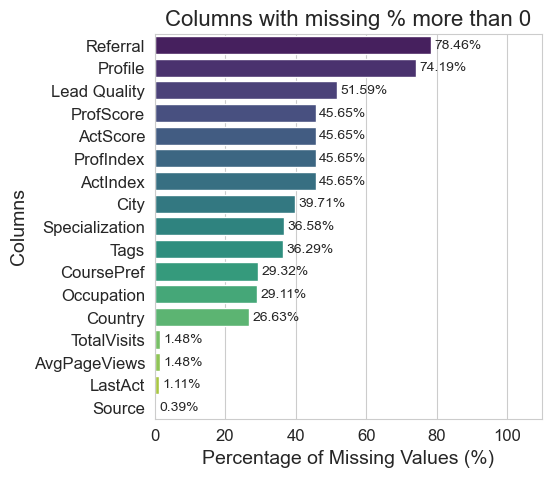

Number of non missing data columns =  20

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'SupplyChainInfo', 'DMInfo', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  17

List of all columns with missing data =  ['Referral', 'Profile', 'Lead Quality', 'ProfScore', 'ActScore', 'ProfIndex', 'ActIndex', 'City', 'Specialization', 'Tags', 'CoursePref', 'Occupation', 'Country', 'TotalVisits', 'AvgPageViews', 'LastAct', 'Source']



In [19]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

#### Manual Feature Categorization

For a deeper understanding of our dataset, we'll manually categorize each feature based on its description and domain knowledge:

**Informative**:
`ProspectID, LeadNum`

- `LeadNum`and`ProspectID`, are unique identifier, but specific to each lead. They are unique for every entry implies no analytical value for modeling. It primarily serves administrative or database-related tasks. Thus, `LeadNum` should be categorized as **Informative**.

**Numerical**:
`ActIndex, ActScore, AvgPageViews, ProfScore, ProfIndex, WebsiteTime, TotalVisits`
- These are columns with continuous or ordinal values. They can be directly used in mathematical calculations.

**Categorical**:
`City, Converted, Country, CoursePref, DMInfo, DigitalAd, DontCall, DontEmail, ForumVisit, InterviewCopy, LastAct, LastMajorAct, Lead Quality, MagazineSub, NewsArticle, Occupation, OnlineSearch, Origin, PayByCheque, Profile, ReadNews, Recommended, Referral, Source, Specialization, SupplyChainInfo, Tags, WantsUpdates`
- These are columns with discrete values, often text or codes, representing different categories or labels

#### Searching for some pattern in missing values through visual inspection 

In [20]:
def visualize_missing_correlation(df: pd.DataFrame, cols: list = None) -> pd.DataFrame:
    """
    Visualize correlations between missing values of the specified columns in the dataframe.
    
    Parameters:
    ----------
    df : pd.DataFrame
        The input dataframe.
    cols : list, optional
        List of columns to consider for the correlation. 
        If not provided, all columns in the dataframe will be considered.
    
    Returns:
    -------
    pd.DataFrame
        A dataframe where each row corresponds to a column with missing values and the subsequent columns 
        group other columns based on the correlation of their missing values.
    """
    
    # If no specific columns are provided, consider all columns
    if not cols:
        cols = df.columns

    # Create a binary dataframe indicating missing values
    missing_df = df[cols].isnull().astype(int)

    # Get columns that have at least one missing value
    cols_with_missing = missing_df.columns[missing_df.sum() > 0]

    # If no columns with missing values, exit
    if not len(cols_with_missing):
        print("No columns with missing values!")
        return

    # Compute the absolute correlation matrix for columns with missing values
    corr_matrix = missing_df[cols_with_missing].corr().abs() * 100

    # Define correlation bins
    bins = [100, 80, 60, 50]

    # Create an output dataframe
    corr_df_miss = pd.DataFrame(index=corr_matrix.columns)

    for i in range(len(bins) - 1):
        bin_name = f"[{int(bins[i])} {int(bins[i+1])}]"
        corr_df_miss[bin_name] = [list(corr_matrix[(corr_matrix[col] <= bins[i]) & (corr_matrix[col] > bins[i+1])].index) 
                                  for col in corr_matrix.columns]

    # Plot the heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Between Missing Values of Features")
    plt.show()
    
    return corr_df_miss

# The function will now return the corr_df_miss dataframe after plotting.


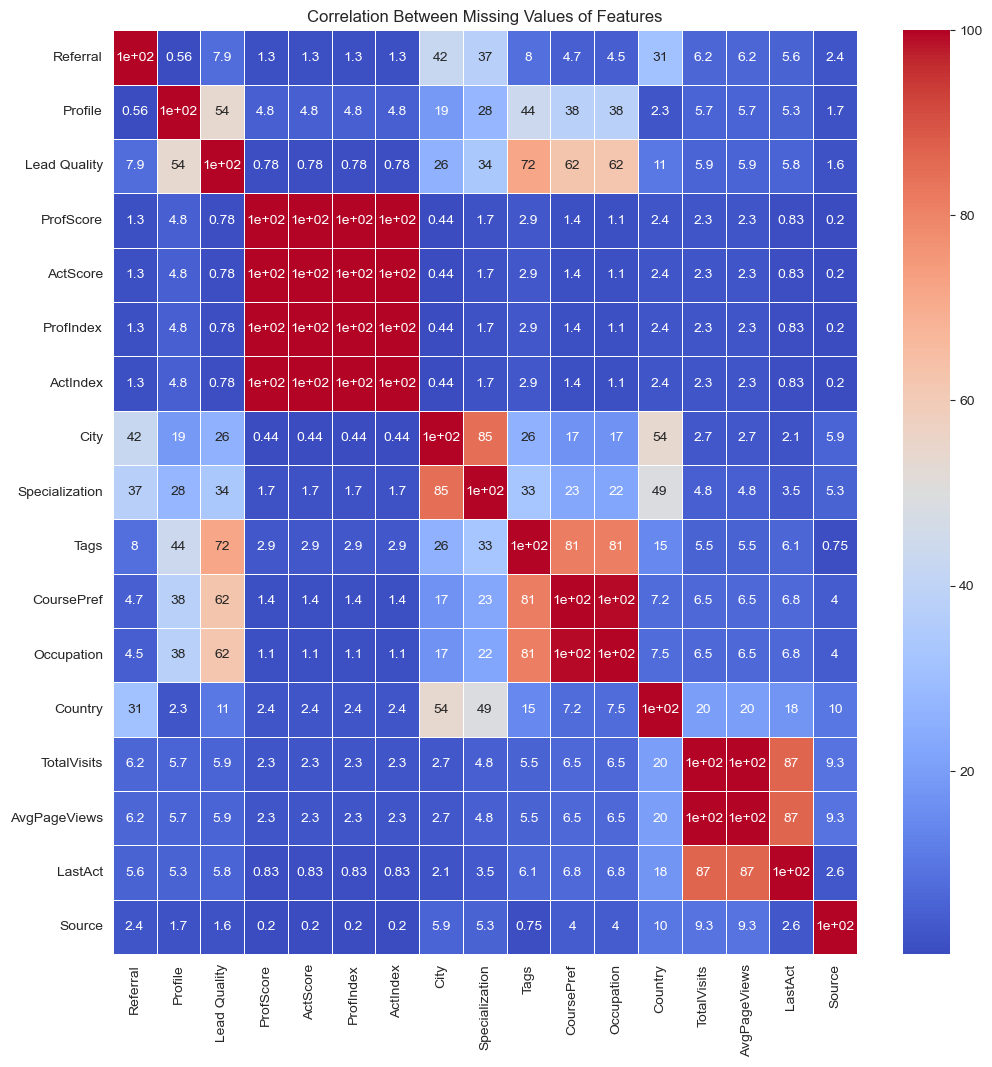

In [21]:
corr_df_miss = visualize_missing_correlation(df, missing_data_columns_names)

In [22]:
corr_df_miss

,[100 80],[80 60],[60 50]
Referral,[Referral],[],[]
Profile,[Profile],[],[Lead Quality]
Lead Quality,[Lead Quality],"[Tags, CoursePref, Occupation]",[Profile]
ProfScore,"[ProfScore, ActScore, ProfIndex, ActIndex]",[],[]
ActScore,"[ProfScore, ActScore, ProfIndex, ActIndex]",[],[]
ProfIndex,"[ProfScore, ActScore, ProfIndex, ActIndex]",[],[]
ActIndex,"[ProfScore, ActScore, ProfIndex, ActIndex]",[],[]
City,"[City, Specialization]",[],[Country]
Specialization,"[City, Specialization]",[],[]
Tags,"[Tags, CoursePref, Occupation]",[Lead Quality],[]


In [23]:
corr_df_miss.index

Index(['Referral', 'Profile', 'Lead Quality', 'ProfScore', 'ActScore',
       'ProfIndex', 'ActIndex', 'City', 'Specialization', 'Tags', 'CoursePref',
       'Occupation', 'Country', 'TotalVisits', 'AvgPageViews', 'LastAct',
       'Source'],
      dtype='object')

In [24]:
corr_df_miss.columns

Index(['[100 80]', '[80 60]', '[60 50]'], dtype='object')

## Analyzing Correlation Between Missing Values

To understand the patterns in missing data, we have compared the theoretical groupings of columns (based on domain knowledge and data description) with empirical groupings derived from missing value correlations. This comparison aids in identifying potential patterns or relationships between the missing values in different columns, which can be valuable for both imputation strategies and further analyses.

### Method:
1. **Theoretical Groupings**: These groupings are based on our understanding of the data and the provided column descriptions. By categorizing related columns, we can better appreciate how data might be missing in clusters or related sets.
   
2. **Empirical Groupings (Correlation by Missingness)**: We calculated correlations between the patterns of missing values in different columns. Columns that have a strong correlation in their missing value patterns are likely missing data under similar conditions or due to similar reasons.

### Key Insights:
1. **Agreement between Theoretical and Empirical Groupings**: If a set of columns is theoretically grouped together and also shows a strong correlation in their missingness, it reinforces the idea that they share a commonality in how or why their data might be missing.

2. **Disagreement between Groupings**: Discrepancies between the two groupings could highlight areas where our initial understanding of the data is not aligning with the actual patterns of missingness. This can be an area of investigation to understand potential data collection issues or other external factors.

3. **Columns with No Missing Data**: By identifying columns within a group that have no missing values, we can potentially use them as a reference or as features when imputing missing values in other correlated columns.

4. **Columns with Missing Data**: Recognizing columns within a group that have missing values can guide targeted imputation strategies. For instance, understanding the relationship between two columns can help decide if one can be used to predict or impute the other.

### Implications for Missing Data Handling:
- **Model-Based Imputation**: If two columns are strongly correlated in terms of missingness and have a logical relationship, we can use one column to help predict and impute missing values in the other.
  
- **Data Collection Insights**: Understanding patterns of missingness can provide feedback on the data collection process, highlighting areas where improvements can be made to reduce missing data in the future.
  
- **Feature Engineering**: Recognizing these patterns can also be beneficial for feature engineering, where we might combine features or create new ones based on our findings.

### Conclusion:
This comparison serves as an exploratory step in understanding the intricacies of our dataset. It provides a foundation upon which we can build our data preprocessing, feature engineering, and modeling strategies, ensuring we handle missing values effectively and derive meaningful insights from the data.

In [25]:
def compare_groupings(col_df_info: pd.DataFrame, corr_df_miss: pd.DataFrame, 
                      non_missing_data_columns_names: list, missing_data_columns_names: list) -> pd.DataFrame:
    """
    Compare the theoretical groupings with the empirical groupings based on missing value correlations.
    
    Parameters:
    ----------
    col_df_info : pd.DataFrame
        The dataframe containing columns and their theoretical groupings.
    corr_df_miss : pd.DataFrame
        The dataframe containing columns and their empirical groupings based on missing value correlations.
    non_missing_data_columns_names : list
        List of column names that don't have any missing values.
    missing_data_columns_names : list
        List of column names that have missing values.
    
    Returns:
    -------
    pd.DataFrame
        A dataframe showing the comparison between the theoretical and empirical groupings.
    """
    
    comparison_results = []

    # Iterate through each column in corr_df_miss
    for col in corr_df_miss.index:
        # Fetch the theoretical category for the column
        theoretical_group = col_df_info[col_df_info['Category'] == col_df_info[col_df_info['Variables'] == col]['Category'].values[0]]['Variables'].tolist()
        
        # Split the theoretical_group into two groups
        no_missing_data_group = [x for x in theoretical_group if x in non_missing_data_columns_names]
        missing_data_group = [x for x in theoretical_group if x in missing_data_columns_names]
        
        # Fetch the correlated columns for the column from the '[100 80]' bin
        correlated_columns = corr_df_miss.loc[col, '[100 80]']

        # Find common column names
        common_with_no_missing = list(set(correlated_columns).intersection(no_missing_data_group))
        common_with_missing = list(set(correlated_columns).intersection(missing_data_group))

        comparison_results.append({
            'Column Name': col,
            'CorrelatedByMissingness': correlated_columns,
            'PresumedGrouping_No_Missing_Data': no_missing_data_group,
            'Common_No_Missing_Data': common_with_no_missing,
            'PresumedGrouping_Missing_Data': missing_data_group,
            'Common_Missing_Data': common_with_missing
        })

    # Convert the results list to a dataframe
    comparison_df = pd.DataFrame(comparison_results)
    
    # Set 'Column Name' as index
    comparison_df.set_index('Column Name', inplace=True)
    
    return comparison_df


In [26]:
compare_groupings(col_df_info, corr_df_miss,  non_missing_data_columns_names, missing_data_columns_names)

,CorrelatedByMissingness,PresumedGrouping_No_Missing_Data,Common_No_Missing_Data,PresumedGrouping_Missing_Data,Common_Missing_Data
Column Name,,,,,
Referral,[Referral],"[MagazineSub, Recommended, Origin, ReadNews, OnlineSearch, NewsArticle, ForumVisit, DigitalAd]",[],"[Referral, Source]",[Referral]
Profile,[Profile],[],[],"[Profile, Lead Quality, ProfIndex, ProfScore, Specialization, Tags]",[Profile]
Lead Quality,[Lead Quality],[],[],"[Profile, Lead Quality, ProfIndex, ProfScore, Specialization, Tags]",[Lead Quality]
ProfScore,"[ProfScore, ActScore, ProfIndex, ActIndex]",[],[],"[Profile, Lead Quality, ProfIndex, ProfScore, Specialization, Tags]","[ProfScore, ProfIndex]"
ActScore,"[ProfScore, ActScore, ProfIndex, ActIndex]","[WebsiteTime, LastMajorAct]",[],"[ActIndex, ActScore, TotalVisits, AvgPageViews, LastAct]","[ActIndex, ActScore]"
ProfIndex,"[ProfScore, ActScore, ProfIndex, ActIndex]",[],[],"[Profile, Lead Quality, ProfIndex, ProfScore, Specialization, Tags]","[ProfScore, ProfIndex]"
ActIndex,"[ProfScore, ActScore, ProfIndex, ActIndex]","[WebsiteTime, LastMajorAct]",[],"[ActIndex, ActScore, TotalVisits, AvgPageViews, LastAct]","[ActIndex, ActScore]"
City,"[City, Specialization]","[ProspectID, LeadNum]",[],"[City, Occupation, Country]",[City]
Specialization,"[City, Specialization]",[],[],"[Profile, Lead Quality, ProfIndex, ProfScore, Specialization, Tags]",[Specialization]


In [27]:
#  Pairwise study for inital visula pattern detection

In [28]:
def column_pairwise_missing_info(df: pd.DataFrame, cols):
    """
    Returns a dataframe with concise column names containing missing values information 
    for combinations of columns in the dataframe. A detailed legend for the columns is also printed.
    
    Parameters:
    - df: The input dataframe
    - cols: List of columns to check for missing values
    
    Returns:
    - DataFrame with missing values information
    """
    
    # Validate if there are enough columns to take two at a time
    if len(cols) < 2:
        return pd.DataFrame(columns=['Cols', 'M1', 'P1', 'M2', 'P2', 'Both_M', 'Only_M1', 'Only_M2'])
    
    # Print column legend with more detailed information
    print("Column Legend & How to Interpret:\n")
    print("- Cols: Pair of columns being analyzed. For example, if it shows 'A, B', we are analyzing columns A and B.")
    print("- M1 & M2: Number of missing values for first and second columns respectively. For 'A, B', M1 refers to missing values in column A and M2 refers to column B.")
    print("- P1 & P2: Percentage of missing values for first and second columns respectively. It tells the proportion of missing values in each column.")
    print("- Both_M: Number of rows where both columns have missing values. This shows overlapping missing data.")
    print("- Only_M1 & Only_M2: Rows where only one column in the pair has a missing value. For 'A, B', Only_M1 counts rows where A is missing but B is not and vice versa for Only_M2.")
    print("="*80)  # Horizontal line for clarity
    
    # Data storage
    data = []
    
    # Iterate through combinations of columns
    for c1, c2 in combinations(cols, 2):
        # Calculate missing values and percentages
        c1_missing = df[c1].isnull().sum()
        c2_missing = df[c2].isnull().sum()
        p1 = (c1_missing / len(df)) * 100
        p2 = (c2_missing / len(df)) * 100
        
        # Calculate rows where both columns are missing values
        both_missing = df[(df[c1].isnull()) & (df[c2].isnull())].shape[0]
        
        # Calculate rows where one column is missing and the other is not
        c1_missing_c2_present = df[(df[c1].isnull()) & (~df[c2].isnull())].shape[0]
        c2_missing_c1_present = df[(~df[c1].isnull()) & (df[c2].isnull())].shape[0]
        
        # Append data
        data.append([f"{c1}, {c2}", c1_missing, p1, c2_missing, p2, both_missing, c1_missing_c2_present, c2_missing_c1_present])
    
    # Convert to DataFrame with concise column names
    result_df = pd.DataFrame(data, columns=['Cols', 'M1', 'P1', 'M2', 'P2', 'Both_M', 'Only_M1', 'Only_M2'])
    
    return result_df

In [29]:
cols =['Country','City']
column_pairwise_missing_info(df, cols)

Column Legend & How to Interpret:

- Cols: Pair of columns being analyzed. For example, if it shows 'A, B', we are analyzing columns A and B.
- M1 & M2: Number of missing values for first and second columns respectively. For 'A, B', M1 refers to missing values in column A and M2 refers to column B.
- P1 & P2: Percentage of missing values for first and second columns respectively. It tells the proportion of missing values in each column.
- Both_M: Number of rows where both columns have missing values. This shows overlapping missing data.
- Only_M1 & Only_M2: Rows where only one column in the pair has a missing value. For 'A, B', Only_M1 counts rows where A is missing but B is not and vice versa for Only_M2.


,Cols,M1,P1,M2,P2,Both_M,Only_M1,Only_M2
0,"Country, City",2461,26.634199,3669,39.707792,2055,406,1614


In [30]:
def Single_plot_distribution(df, col):
    """
    Plots the distribution of values in col as percentages, treating missing values as a distinct category.
    
    Parameters:
    - df: The input dataframe
    - col: The column whose value counts will be plotted
    """
    
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Replace NaN values with custom 'Missing' category name
    df_copy[col].fillna(f"Missing_{col}", inplace=True)
    
    # Display unique categories and their counts for col in a tabulated format
    unique_values = df_copy[col].unique()
    counts = df_copy[col].value_counts().reindex(unique_values).fillna(0).astype(int).tolist()
    print(f"{col} column has:")
    print(tabulate(zip(unique_values, counts), headers=["Unique Values", "Counts"], tablefmt="grid"))
    print("="*80)  # Horizontal line for clarity
    
    # Calculate the percentage distribution
    distribution_percentages = df_copy[col].value_counts(normalize=True).mul(100)
    distribution_absolute = df_copy[col].value_counts()
    
    # Set the figure height dynamically based on the number of unique categories
    plt.figure(figsize=(10, 0.8 * len(distribution_percentages)))
    
    # Plot the percentage distribution
    ax = sns.barplot(y=distribution_percentages.index, x=distribution_percentages.values, order=distribution_percentages.index)
    ax.set_xlim(0, 100)
    
    # Add percentage and absolute count annotations to bars
    for idx, p in enumerate(ax.patches):
        category_name = distribution_percentages.index[idx]
        percentage = '{:.1f}%'.format(p.get_width())
        absolute = f' ({distribution_absolute[category_name]})'
        x = p.get_x() + p.get_width() + 0.5
        y = p.get_y() + p.get_height() / 2
        if p.get_width() < 10:
            ax.annotate(percentage + absolute, (x, y), ha='left')
        else:
            ax.annotate(percentage + absolute, (p.get_x() + 1, y), ha='left', color='white')
    
    plt.title(f'Distribution of {col}', fontsize=15)
    plt.xlabel('Percentage')
    plt.ylabel(f'{col} Categories')
    plt.tight_layout()
    plt.show()

In [31]:
def Multi_plot_distributions(df, primary_category, distribution_category):
    """
    Plots the distribution of values in distribution_category for each category of primary_category 
    as percentages, treating missing values as a distinct category.
    
    Parameters:
    - df: The input dataframe
    - primary_category: The primary column for which distributions of distribution_category will be plotted
    - distribution_category: The column whose value counts will be plotted for each category of primary_category
    """
    
    # Create a copy of the dataframe to avoid modifying the original data
    df_copy = df.copy()
    
    # Replace NaN values with custom 'Missing' category names
    df_copy[primary_category].fillna(f"Missing_{primary_category}", inplace=True)
    df_copy[distribution_category].fillna(f"Missing_{distribution_category}", inplace=True)
    
    # Display unique categories and their counts for primary_category in a tabulated format
    unique_primary_values = df_copy[primary_category].unique()
    primary_counts = df_copy[primary_category].value_counts().reindex(unique_primary_values).fillna(0).astype(int).tolist()
    print(f"{primary_category} column has:")
    print(tabulate(zip(unique_primary_values, primary_counts), headers=["Unique Values", "Counts"], tablefmt="grid"))
    print("\n")
    
    # Display unique categories and their counts for distribution_category in a tabulated format
    unique_distribution_values = df_copy[distribution_category].unique()
    distribution_counts = df_copy[distribution_category].value_counts().reindex(unique_distribution_values).fillna(0).astype(int).tolist()
    print(f"{distribution_category} column has:")
    print(tabulate(zip(unique_distribution_values, distribution_counts), headers=["Unique Values", "Counts"], tablefmt="grid"))
    print("="*80)  # Horizontal line for clarity
    
    unique_categories = df_copy[primary_category].unique()
    
    for category in unique_categories:
        # Subset the data for the current category of primary_category
        subset_data = df_copy[df_copy[primary_category] == category]
        
        # Calculate the percentage distribution
        total_count = len(subset_data)
        distribution_percentages = subset_data[distribution_category].value_counts(normalize=True).mul(100)
        distribution_absolute = subset_data[distribution_category].value_counts()
        
        # Set the figure height dynamically based on the number of unique categories
        plt.figure(figsize=(10, 0.8 * len(distribution_percentages)))
        
        # Plot the percentage distribution
        ax = sns.barplot(y=distribution_percentages.index, x=distribution_percentages.values, order=distribution_percentages.index)
        ax.set_xlim(0, 100)
        
        # Add percentage and absolute count annotations to bars
        for idx, p in enumerate(ax.patches):
            category_name = distribution_percentages.index[idx]
            percentage = '{:.1f}%'.format(p.get_width())
            absolute = f' ({distribution_absolute[category_name]})'
            x = p.get_x() + p.get_width() + 0.5
            y = p.get_y() + p.get_height() / 2
            if p.get_width() < 10:
                ax.annotate(percentage + absolute, (x, y), ha='left')
            else:
                ax.annotate(percentage + absolute, (p.get_x() + 1, y), ha='left', color='white')
        
        plt.title(f'Distribution of {distribution_category} for {primary_category} = {category}', fontsize=15)
        plt.xlabel('Percentage')
        plt.ylabel(f'{distribution_category} Categories')
        plt.tight_layout()
        plt.show()


In [32]:
distribution_category_col ='City' 
primary_category_col = 'Country' 

# distribution_category_col ='Country'  
# primary_category_col = 'City' 

City column has:
+-----------------------------+----------+
| Unique Values               |   Counts |
+=============================+==========+
| Missing_City                |     3669 |
+-----------------------------+----------+
| Mumbai                      |     3222 |
+-----------------------------+----------+
| Thane & Outskirts           |      752 |
+-----------------------------+----------+
| Other Metro Cities          |      380 |
+-----------------------------+----------+
| Other Cities                |      686 |
+-----------------------------+----------+
| Other Cities of Maharashtra |      457 |
+-----------------------------+----------+
| Tier II Cities              |       74 |
+-----------------------------+----------+


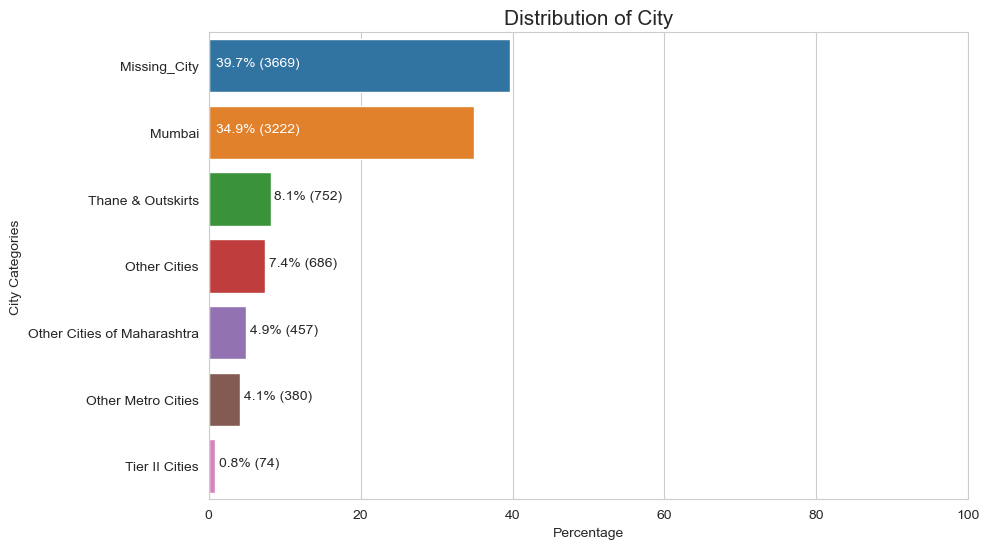

In [33]:
Single_plot_distribution(df, distribution_category_col)


Country column has:
+----------------------+----------+
| Unique Values        |   Counts |
+======================+==========+
| Missing_Country      |     2461 |
+----------------------+----------+
| India                |     6492 |
+----------------------+----------+
| Russia               |        1 |
+----------------------+----------+
| Kuwait               |        4 |
+----------------------+----------+
| Oman                 |        6 |
+----------------------+----------+
| United Arab Emirates |       53 |
+----------------------+----------+
| United States        |       69 |
+----------------------+----------+
| Australia            |       13 |
+----------------------+----------+
| United Kingdom       |       15 |
+----------------------+----------+
| Bahrain              |        7 |
+----------------------+----------+
| Ghana                |        2 |
+----------------------+----------+
| Singapore            |       24 |
+----------------------+----------+
| Qatar 

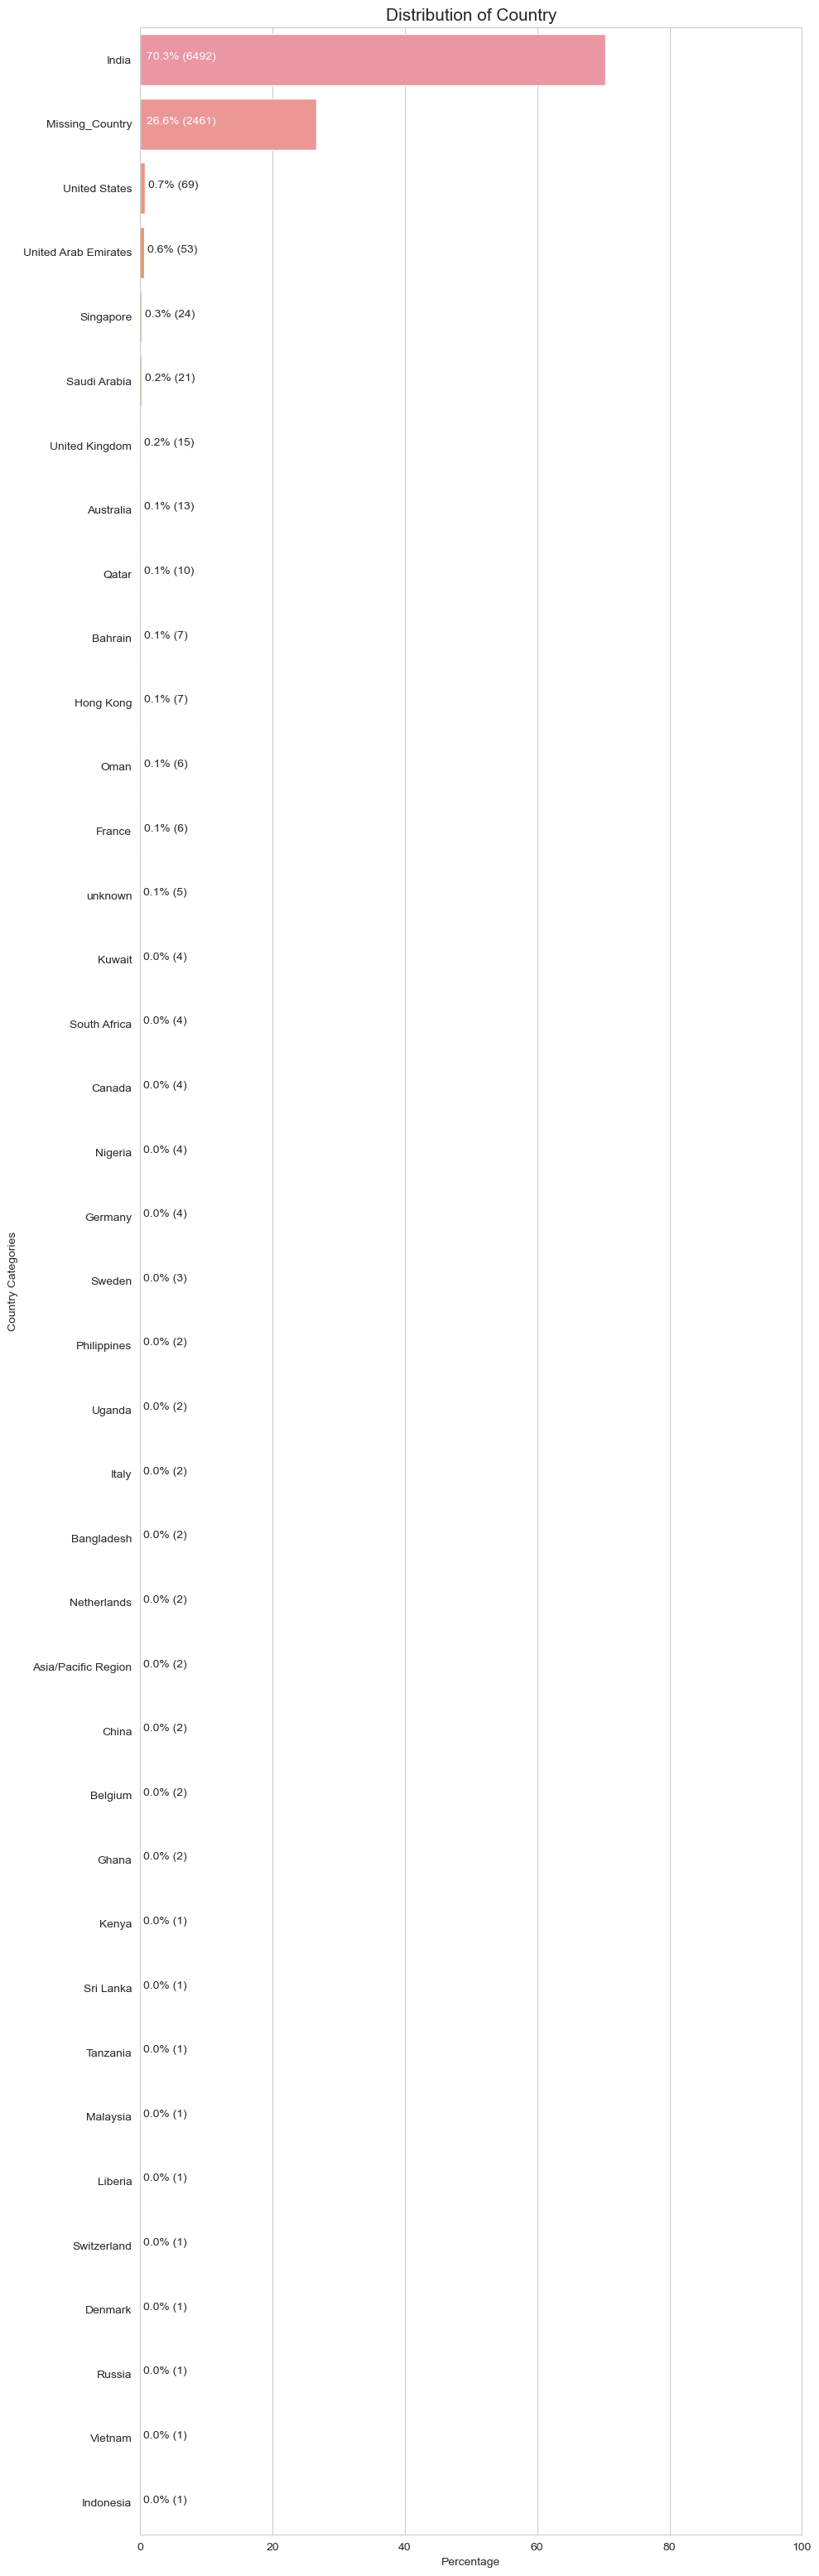

In [34]:
Single_plot_distribution(df, primary_category_col)


#### Rationale for Transformation

The 'Country' column is transformed to focus on the primary category, which is 'India', and aggregate all other categories, including missing values, into a single category. The reasons for this transformation are:

1. **Dominance of 'India' Category:** A vast majority of the leads are from India, making it the primary category of interest.
2. **Handling Missing Data:** A significant portion of the 'Country' column is missing or labeled as 'unknown'. Treating these as a distinct category provides clarity.
3. **Aggregating Sparse Categories:** All countries other than India account for a minor portion of the data. Aggregating these ensures modeling simplicity and robustness.
4. **Modeling Considerations:** Simplifying the column aids in building predictive models by reducing dimensionality without compromising much on information.

In [35]:
# Replace missing values in the "Country" column with "Unknown_Country"
df["Country"].fillna("Unknown_Country", inplace=True)

# Replace countries other than "Unknown_Country" and "India" with "International_Countries"
df["Country"] = df["Country"].apply(lambda x: x if x in ["Unknown_Country", "India"] else "International_Countries")


City column has:
+-----------------------------+----------+
| Unique Values               |   Counts |
+=============================+==========+
| Missing_City                |     3669 |
+-----------------------------+----------+
| Mumbai                      |     3222 |
+-----------------------------+----------+
| Thane & Outskirts           |      752 |
+-----------------------------+----------+
| Other Metro Cities          |      380 |
+-----------------------------+----------+
| Other Cities                |      686 |
+-----------------------------+----------+
| Other Cities of Maharashtra |      457 |
+-----------------------------+----------+
| Tier II Cities              |       74 |
+-----------------------------+----------+


Country column has:
+-------------------------+----------+
| Unique Values           |   Counts |
+=========================+==========+
| Unknown_Country         |     2461 |
+-------------------------+----------+
| India                   |     649

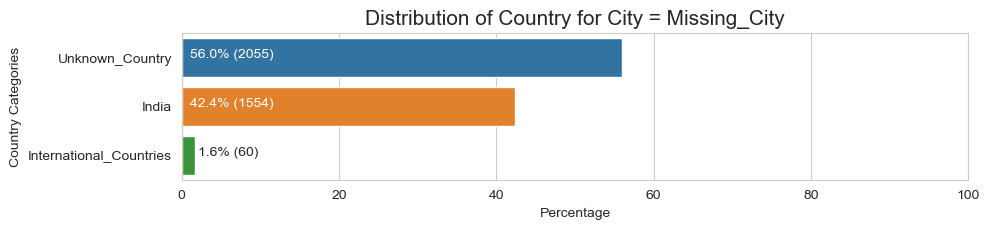

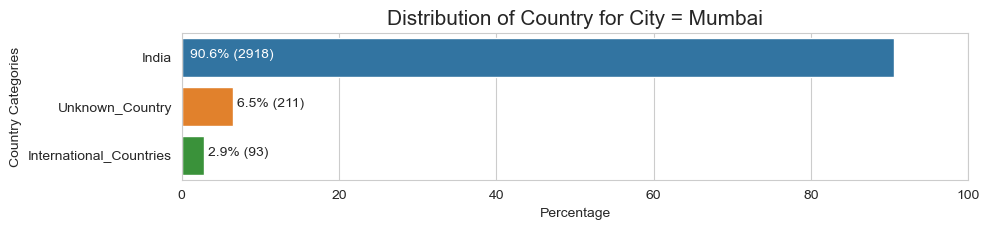

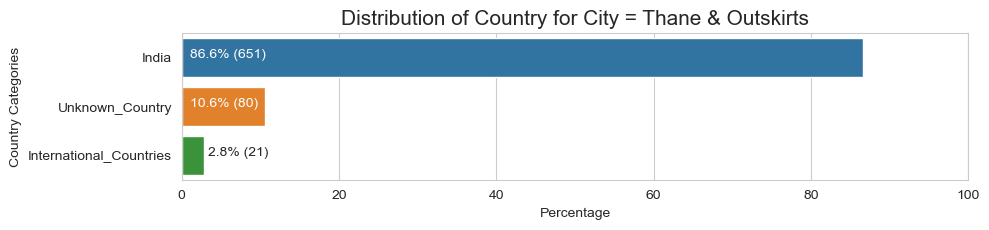

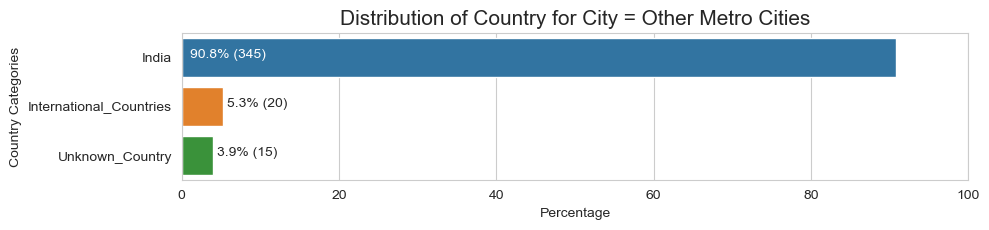

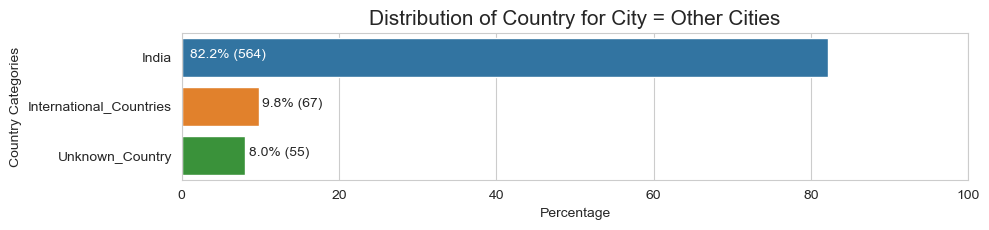

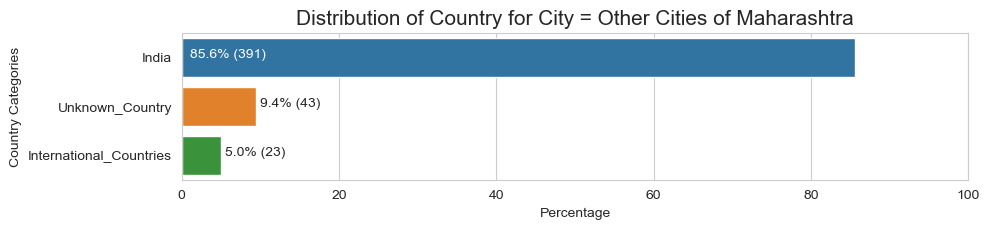

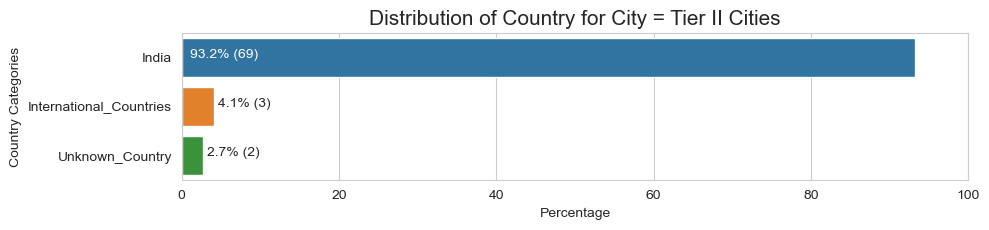

In [36]:
distribution_category_col ='Country'  
primary_category_col = 'City' 

Multi_plot_distributions(df, primary_category_col, distribution_category_col)

In [37]:
# Impute missing 'Country' values with 'India' for rows where 'City' is available
df.loc[(df['Country']=="Unknown_Country") & (df['City'].notnull()), 'Country'] = 'India'

Country column has:
+-------------------------+----------+
| Unique Values           |   Counts |
+=========================+==========+
| Unknown_Country         |     2055 |
+-------------------------+----------+
| India                   |     6898 |
+-------------------------+----------+
| International_Countries |      287 |
+-------------------------+----------+


City column has:
+-----------------------------+----------+
| Unique Values               |   Counts |
+=============================+==========+
| Missing_City                |     3669 |
+-----------------------------+----------+
| Mumbai                      |     3222 |
+-----------------------------+----------+
| Thane & Outskirts           |      752 |
+-----------------------------+----------+
| Other Metro Cities          |      380 |
+-----------------------------+----------+
| Other Cities                |      686 |
+-----------------------------+----------+
| Other Cities of Maharashtra |      457 |
+-------

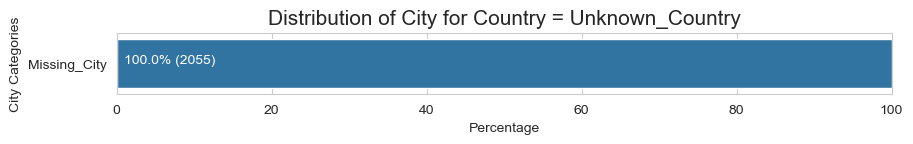

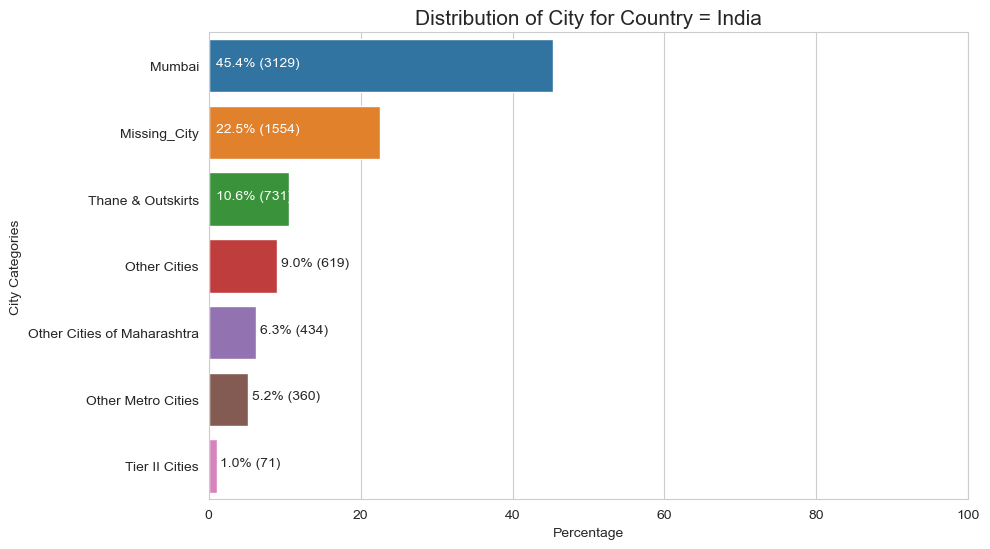

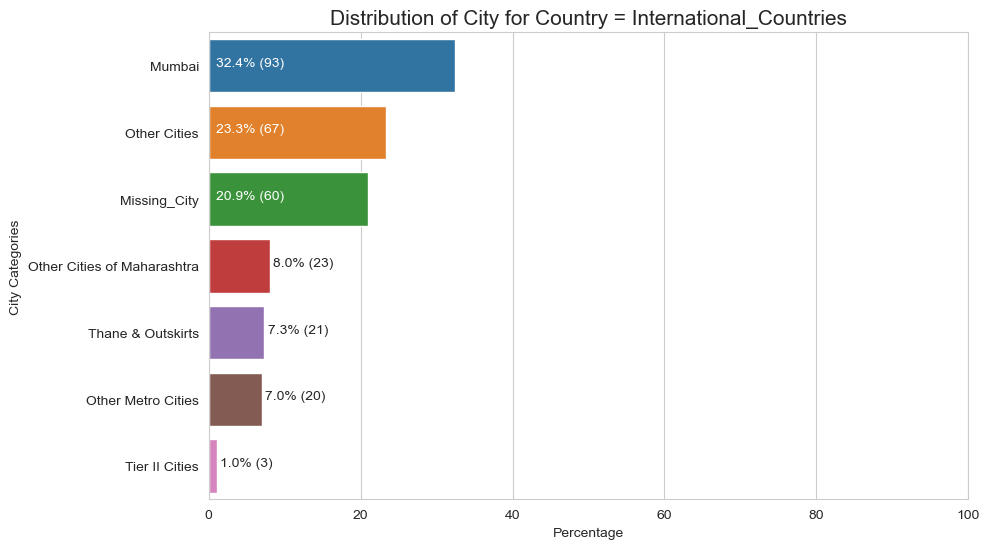

In [38]:
distribution_category_col ='City' 
primary_category_col = 'Country' 

Multi_plot_distributions(df, primary_category_col, distribution_category_col)

Country column has:
+-------------------------+----------+
| Unique Values           |   Counts |
+=========================+==========+
| Unknown_Country         |     2055 |
+-------------------------+----------+
| India                   |     6898 |
+-------------------------+----------+
| International_Countries |      287 |
+-------------------------+----------+


City column has:
+-----------------------------+----------+
| Unique Values               |   Counts |
+=============================+==========+
| Unknown_City                |     3669 |
+-----------------------------+----------+
| Mumbai                      |     3222 |
+-----------------------------+----------+
| Thane & Outskirts           |      752 |
+-----------------------------+----------+
| Other Metro Cities          |      380 |
+-----------------------------+----------+
| Other Cities                |      686 |
+-----------------------------+----------+
| Other Cities of Maharashtra |      457 |
+-------

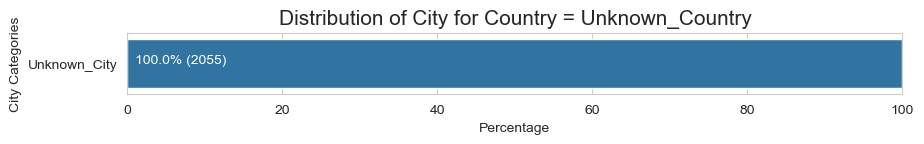

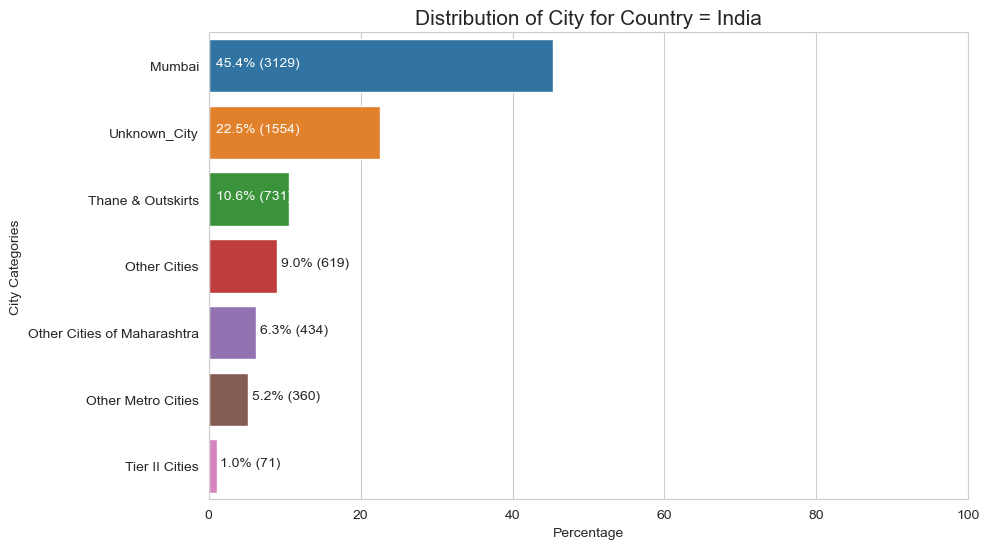

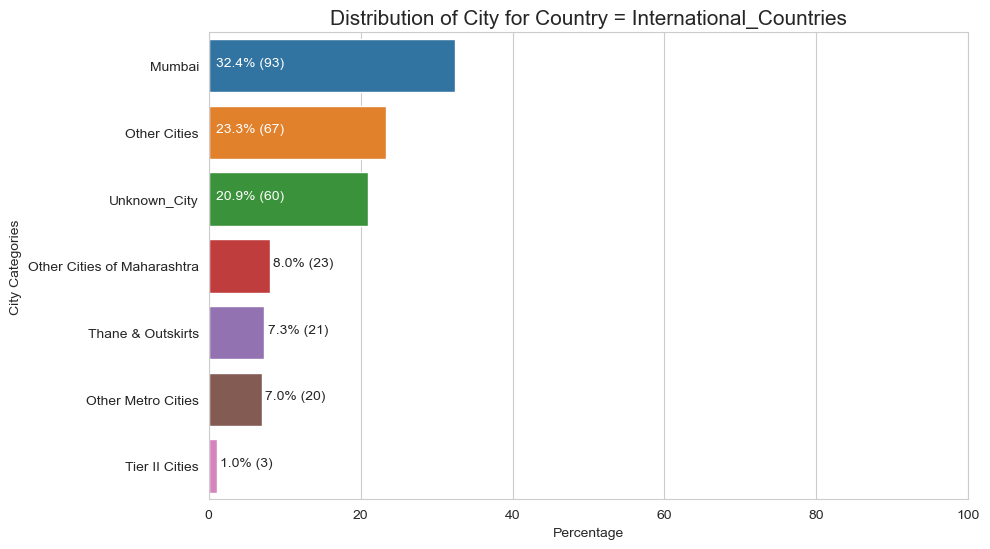

In [39]:
# Replace missing values in the "City" column with "Unknown_City"
df["City"].fillna("Unknown_City", inplace=True)
Multi_plot_distributions(df, primary_category_col, distribution_category_col)

In [40]:
#  Imputing using mode 

In [41]:
def impute_categorical_missing_values(df: pd.DataFrame, primary_column: str, target_column: str) -> pd.DataFrame:
    """
    Impute missing values in the target column based on the distribution of categories in the primary column.
    
    Parameters:
    ----------
    df : pd.DataFrame
        The input dataframe containing the columns to be analyzed.
    primary_column : str
        The name of the primary column based on which imputation decisions will be made.
    target_column : str
        The name of the column where missing values are to be imputed.

    Returns:
    -------
    pd.DataFrame
        The dataframe with missing values in the target column imputed based on the primary column.
    """
    df_copy = df.copy()
    
    # Treat NaN in primary_column as a separate category for the purpose of imputation
    df_copy[primary_column].fillna(f"{primary_column}_nan", inplace=True)
    
    # Calculate modes for each unique value in primary_column, excluding cases where both columns have NaN
    mode_map = df_copy[df_copy[target_column].notna()].groupby(primary_column)[target_column].apply(lambda x: x.mode().iloc[0])
    
    # Fill NaN in target_column based on mode of corresponding category in primary_column
    df_copy[target_column] = df_copy.apply(
        lambda row: mode_map.get(row[primary_column], None) if pd.isnull(row[target_column]) else row[target_column],
        axis=1
    )
    
    # Restore NaN in primary_column
    df_copy[primary_column].replace({f"{primary_column}_nan": None}, inplace=True)
    
    return df_copy

def plot_combined_distribution(df_before: pd.DataFrame, df_after: pd.DataFrame, column: str, title: str, missing_label: str, color_before='blue', color_after='orange'):
    """
    Plot combined distribution of a categorical column before and after imputation.
    
    Parameters:
    ----------
    df_before : pd.DataFrame
        The dataframe representing the distribution before imputation.
    df_after : pd.DataFrame
        The dataframe representing the distribution after imputation.
    column : str
        The name of the column to be plotted.
    title : str
        The title of the plot.
    missing_label : str
        The label used for missing values.
    color_before : str, optional
        Color for bars representing distribution before imputation. Default is 'blue'.
    color_after : str, optional
        Color for bars representing distribution after imputation. Default is 'orange'.
    """
    df_before_copy = df_before.copy()
    df_after_copy = df_after.copy()
    df_before_copy[column].fillna(missing_label, inplace=True)
    df_after_copy[column].fillna(missing_label, inplace=True)
    
    before_counts = df_before_copy[column].value_counts().sort_index()
    after_counts = df_after_copy[column].value_counts().sort_index()
    
    combined_index = before_counts.index.union(after_counts.index)
    before_counts = before_counts.reindex(combined_index, fill_value=0)
    after_counts = after_counts.reindex(combined_index, fill_value=0)
    
    plt.figure(figsize=(12, 6))
    before_counts.plot(kind='bar', position=0, width=0.4, color=color_before, label='Before Imputation')
    after_counts.plot(kind='bar', position=1, width=0.4, color=color_after, label='After Imputation')
    
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

def impute_and_visualize(df: pd.DataFrame, primary_column: str, target_column: str) -> pd.DataFrame:
    """
    Impute missing values in the target column based on the distribution of the primary column and visualize the results.
    
    Parameters:
    ----------
    df : pd.DataFrame
        The input dataframe containing the columns to be analyzed.
    primary_column : str
        The name of the primary column based on which imputation decisions will be made.
    target_column : str
        The name of the column where missing values are to be imputed.

    Returns:
    -------
    pd.DataFrame
        The dataframe with missing values in the target column imputed based on the primary column and visualized.
    """
    imputed_df = impute_categorical_missing_values(df, primary_column, target_column)
    
    missing_label = f"Missing_{target_column}"
    plot_combined_distribution(df, imputed_df, target_column, 
                               f'Distribution of {target_column}: Before vs. After Imputation', missing_label)
    
    return imputed_df


Lead Quality column has:
+----------------------+----------+
| Unique Values        |   Counts |
+======================+==========+
| Low in Relevance     |      583 |
+----------------------+----------+
| Missing_Lead Quality |     4767 |
+----------------------+----------+
| Might be             |     1560 |
+----------------------+----------+
| Not Sure             |     1092 |
+----------------------+----------+
| Worst                |      601 |
+----------------------+----------+
| High in Relevance    |      637 |
+----------------------+----------+


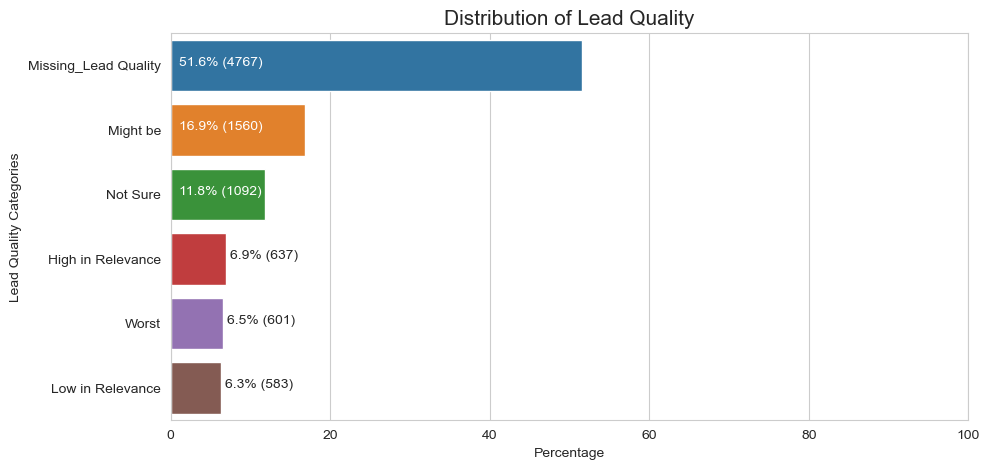

In [42]:
Single_plot_distribution(df,'Lead Quality')

Tags column has:
+---------------------------------------------------+----------+
| Unique Values                                     |   Counts |
+===================================================+==========+
| Interested in other courses                       |      513 |
+---------------------------------------------------+----------+
| Ringing                                           |     1203 |
+---------------------------------------------------+----------+
| Will revert after reading the email               |     2072 |
+---------------------------------------------------+----------+
| Missing_Tags                                      |     3353 |
+---------------------------------------------------+----------+
| Lost to EINS                                      |      175 |
+---------------------------------------------------+----------+
| In confusion whether part time or DLP             |        5 |
+---------------------------------------------------+----------+
| Busy  

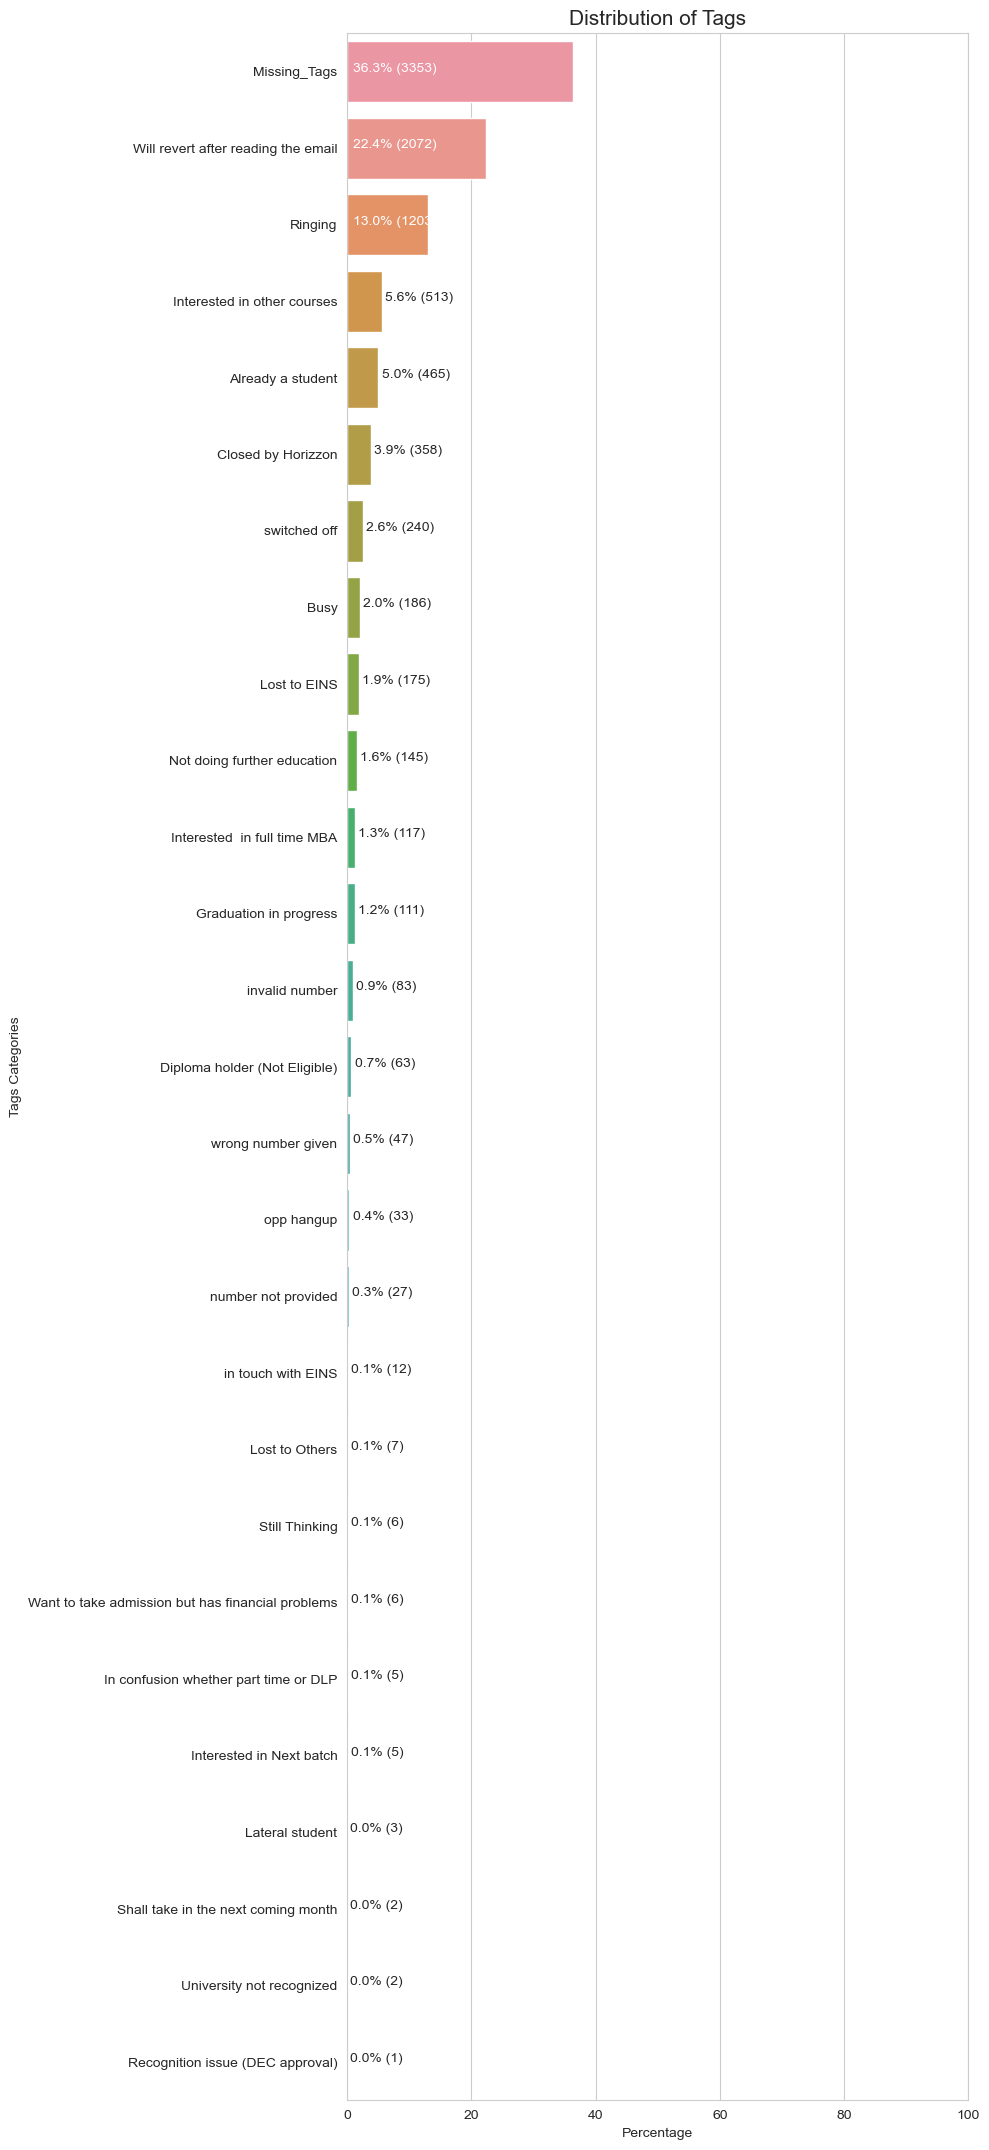

In [43]:
Single_plot_distribution(df,'Tags')

Lead Quality column has:
+----------------------+----------+
| Unique Values        |   Counts |
+======================+==========+
| Low in Relevance     |      583 |
+----------------------+----------+
| Missing_Lead Quality |     4767 |
+----------------------+----------+
| Might be             |     1560 |
+----------------------+----------+
| Not Sure             |     1092 |
+----------------------+----------+
| Worst                |      601 |
+----------------------+----------+
| High in Relevance    |      637 |
+----------------------+----------+


Tags column has:
+---------------------------------------------------+----------+
| Unique Values                                     |   Counts |
+===================================================+==========+
| Interested in other courses                       |      513 |
+---------------------------------------------------+----------+
| Ringing                                           |     1203 |
+-------------------------

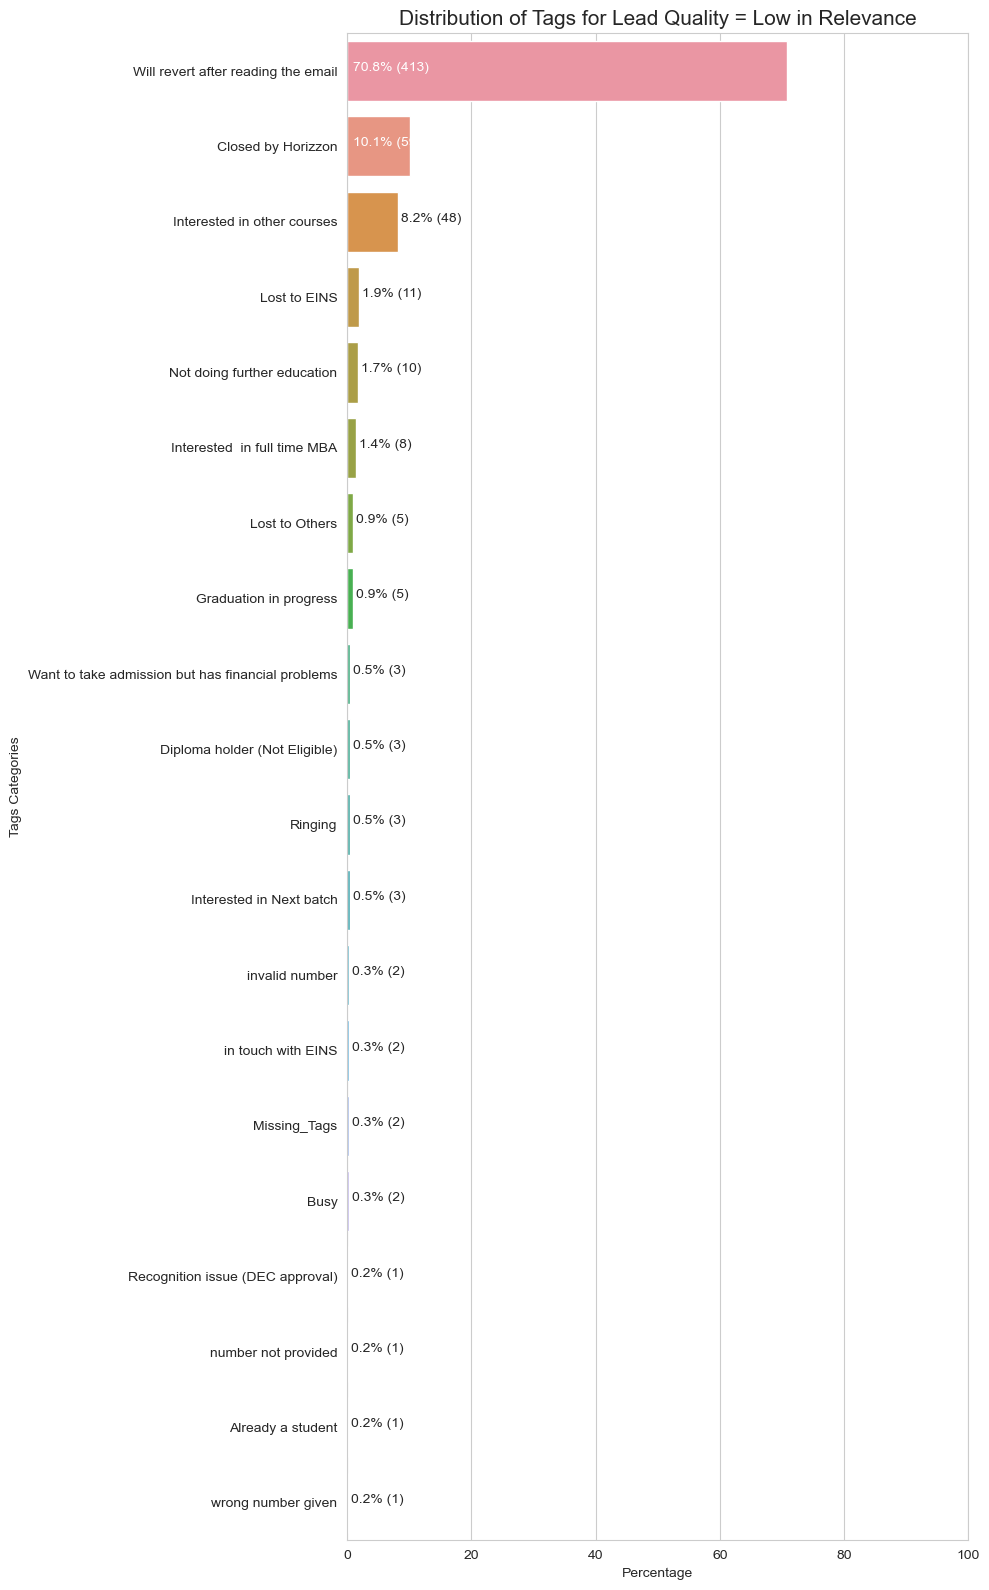

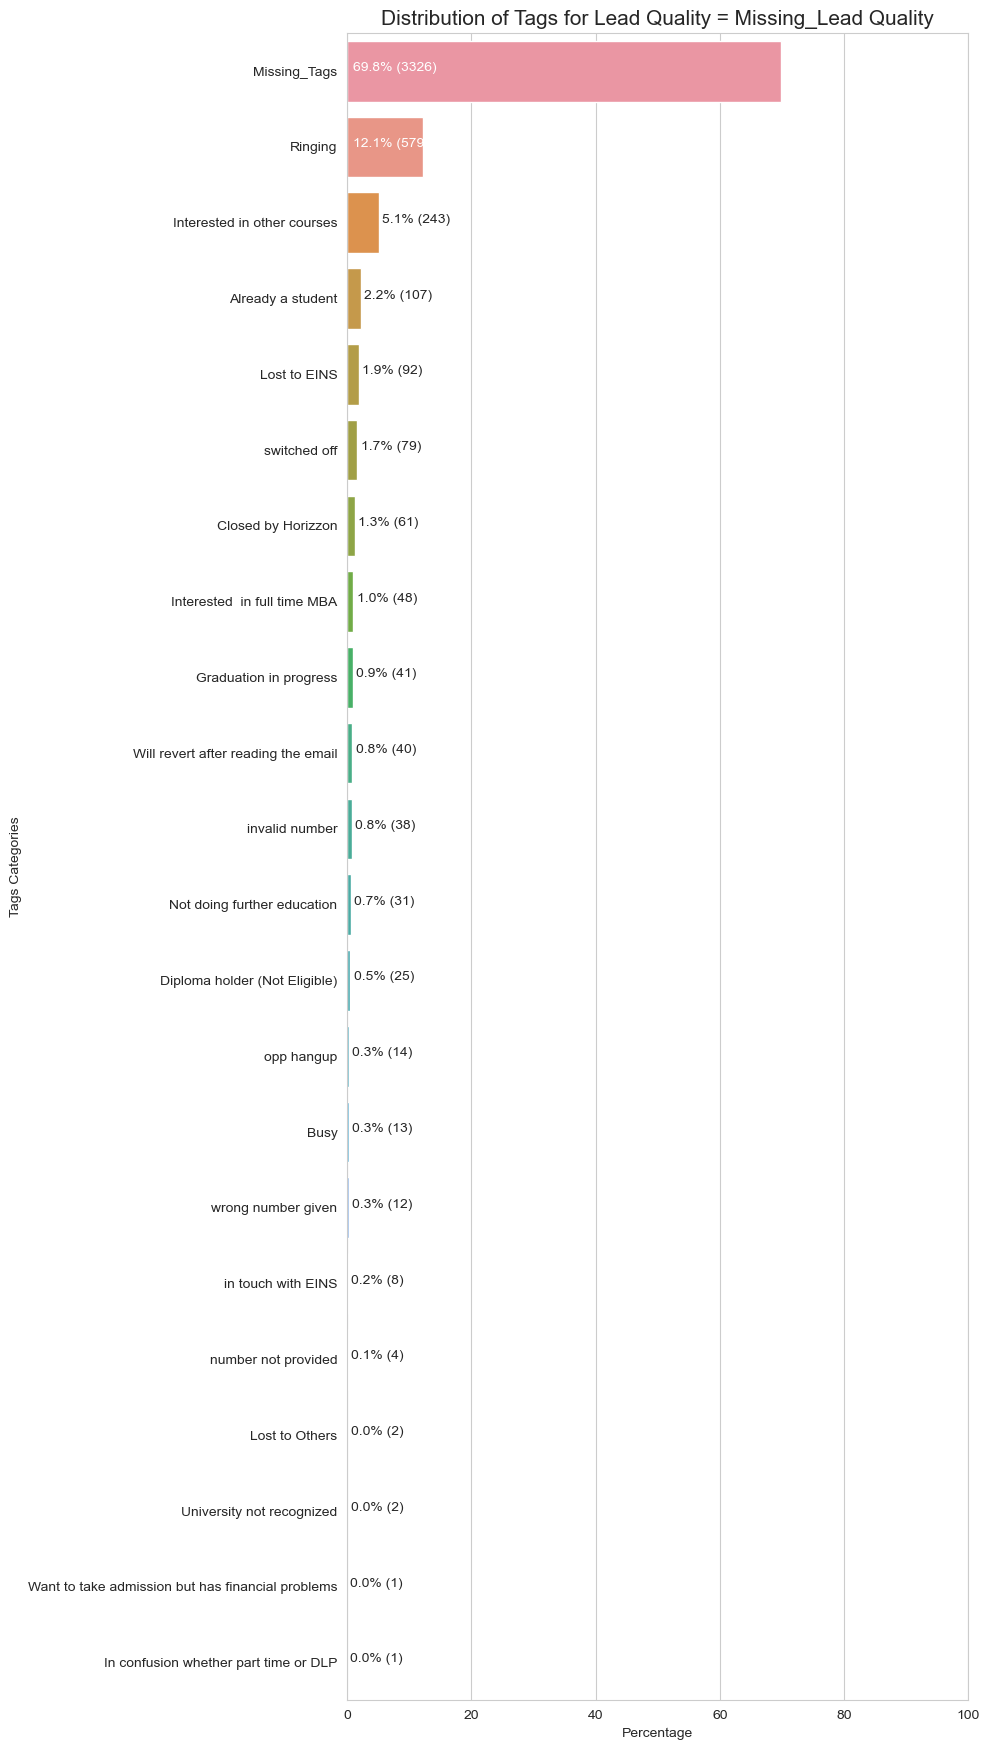

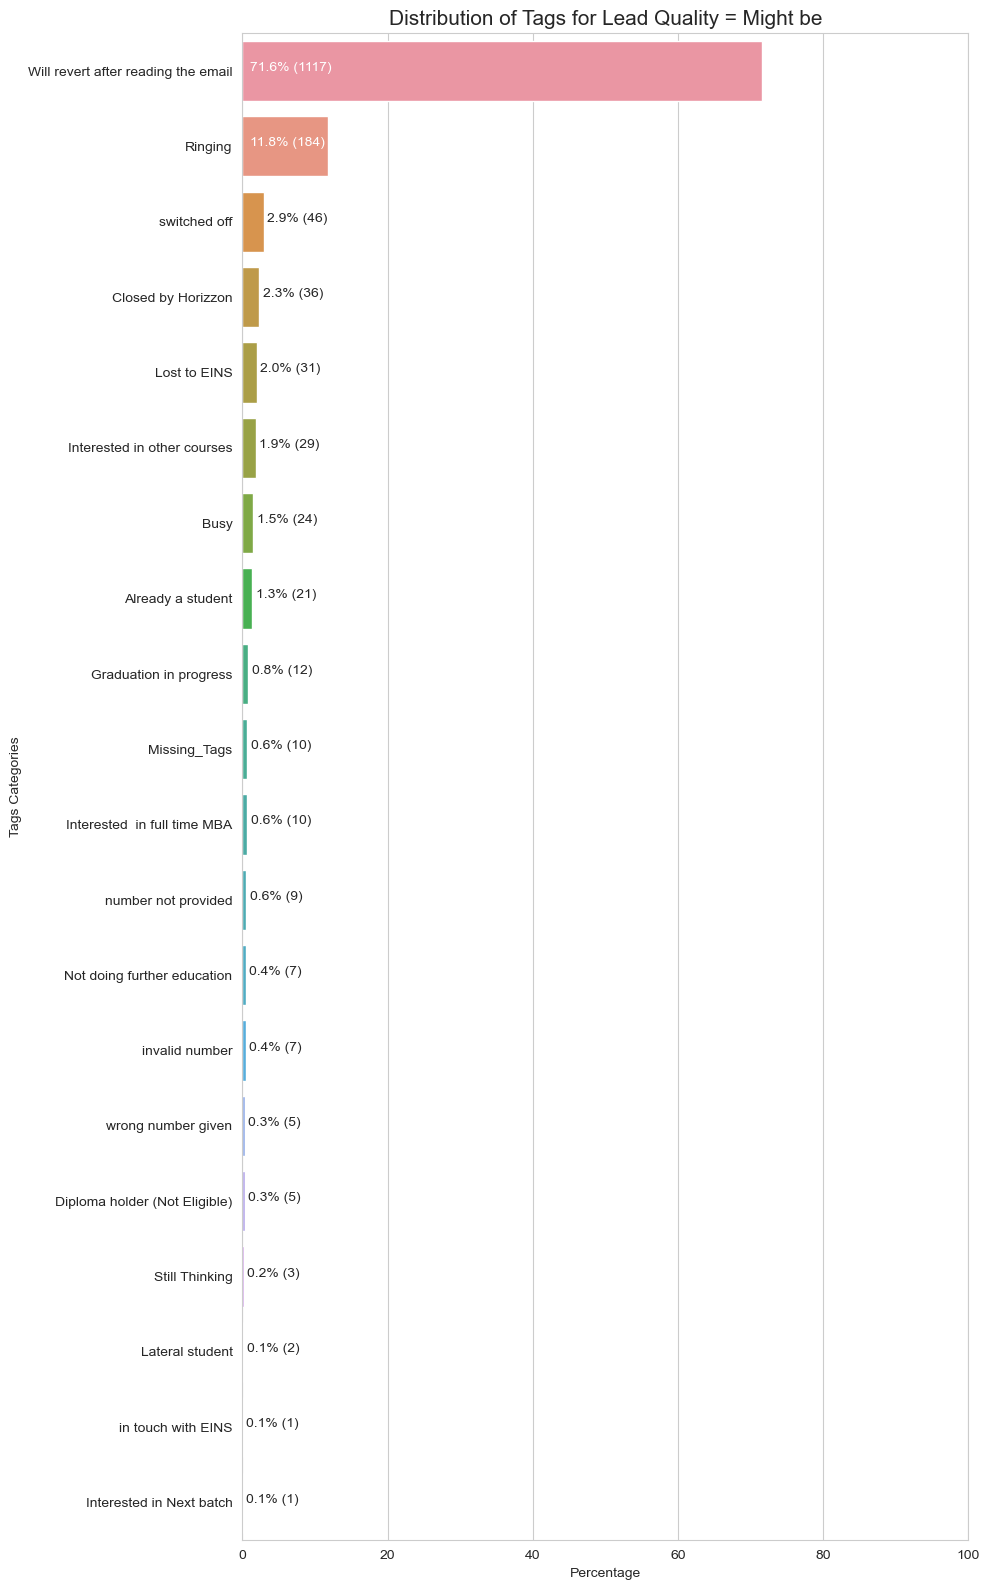

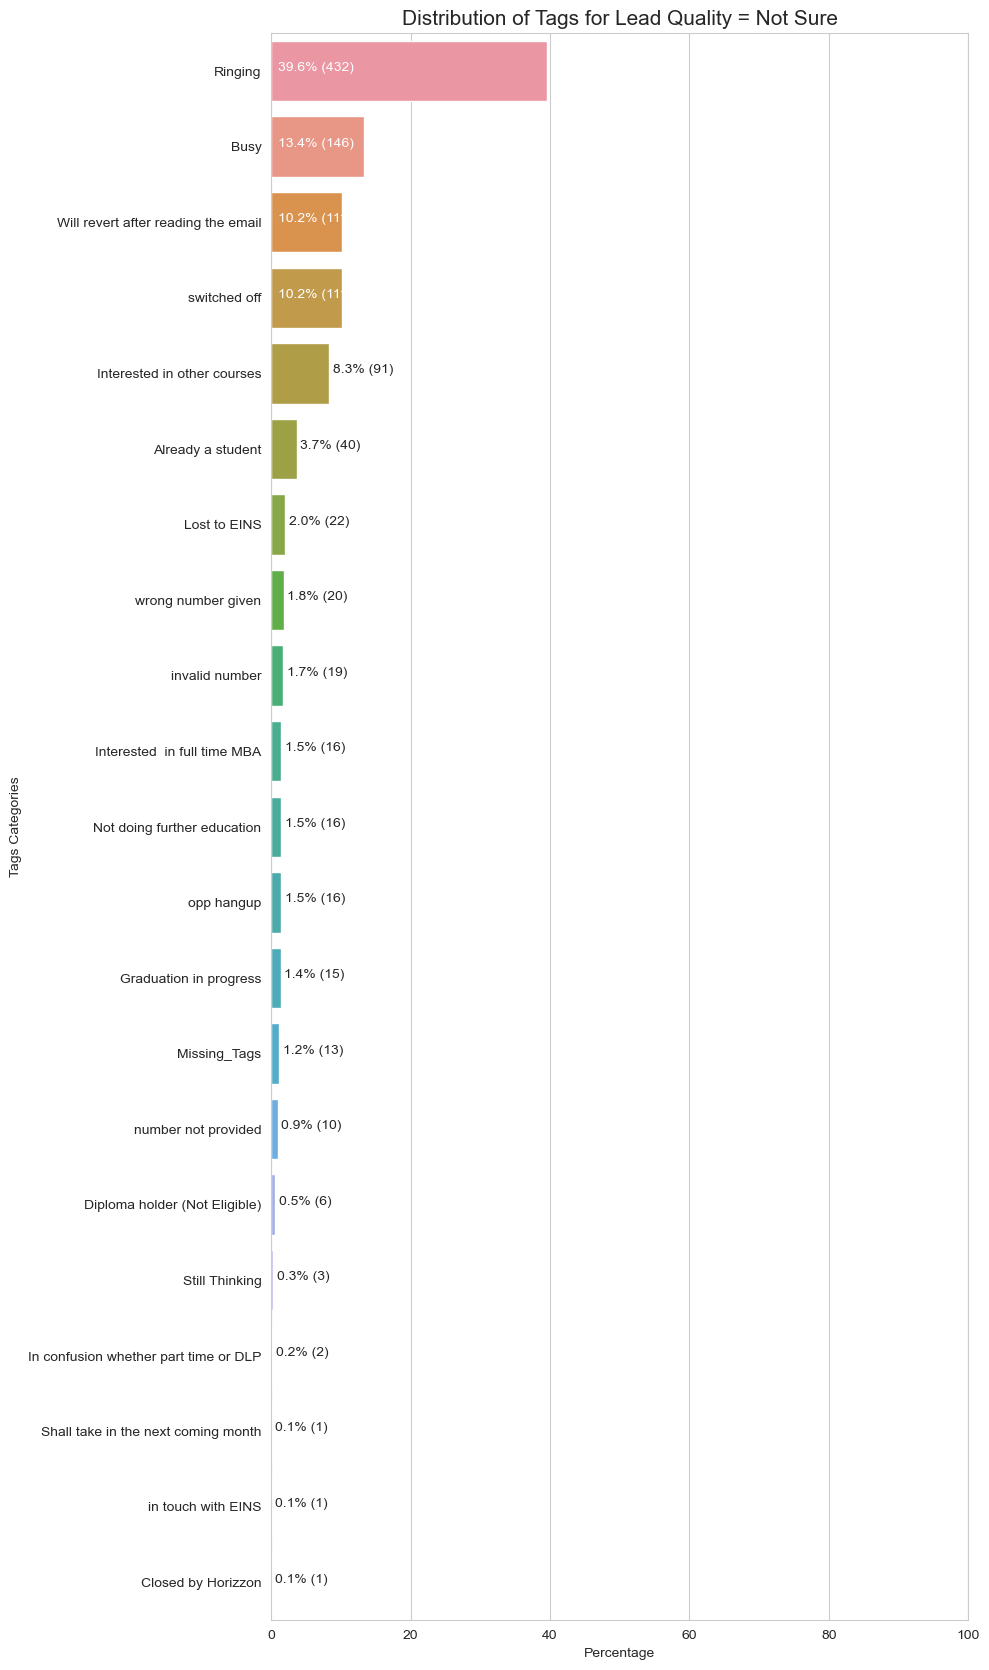

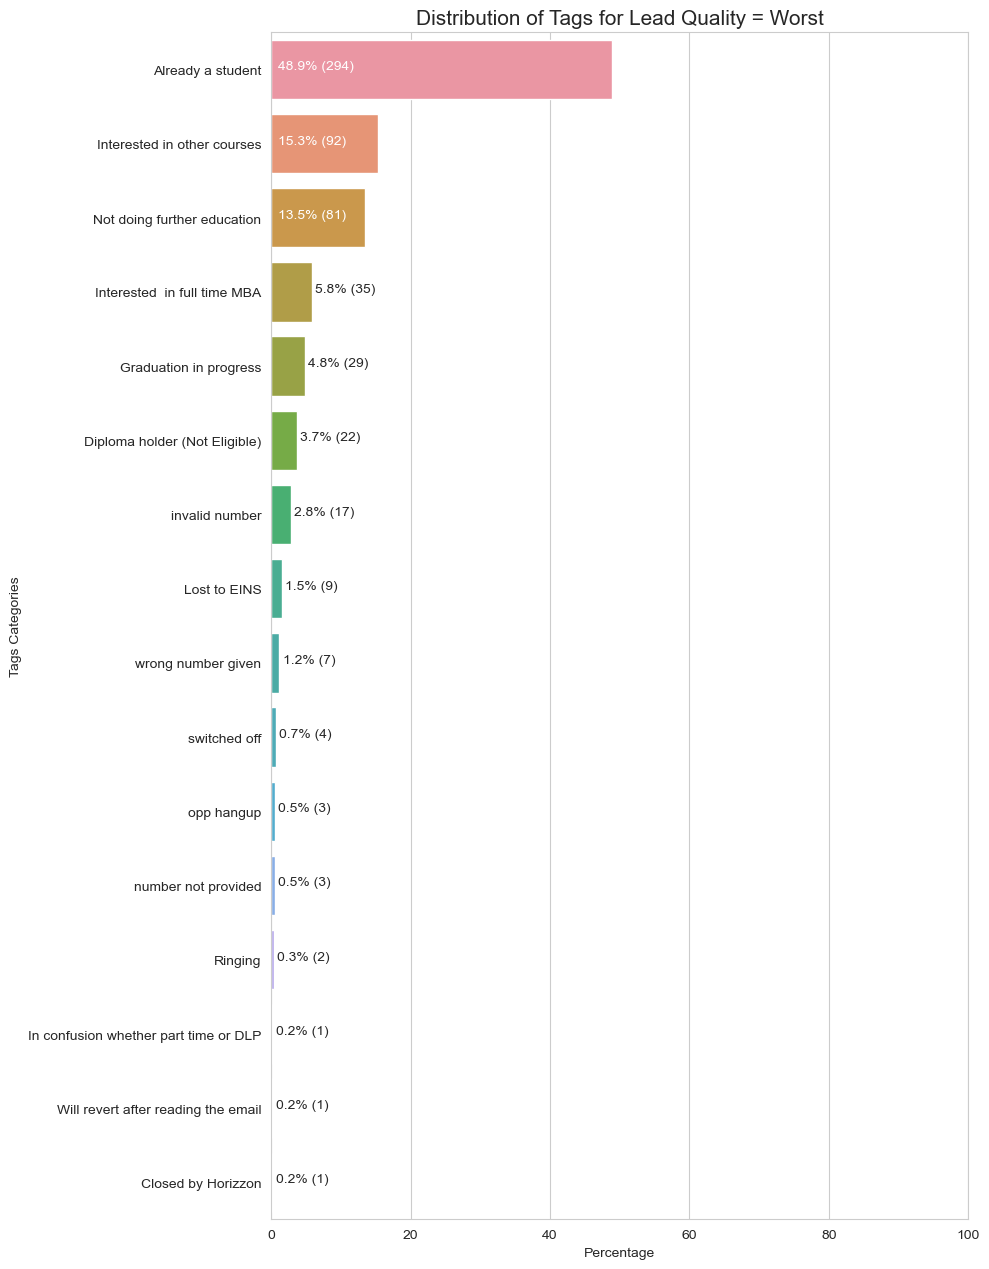

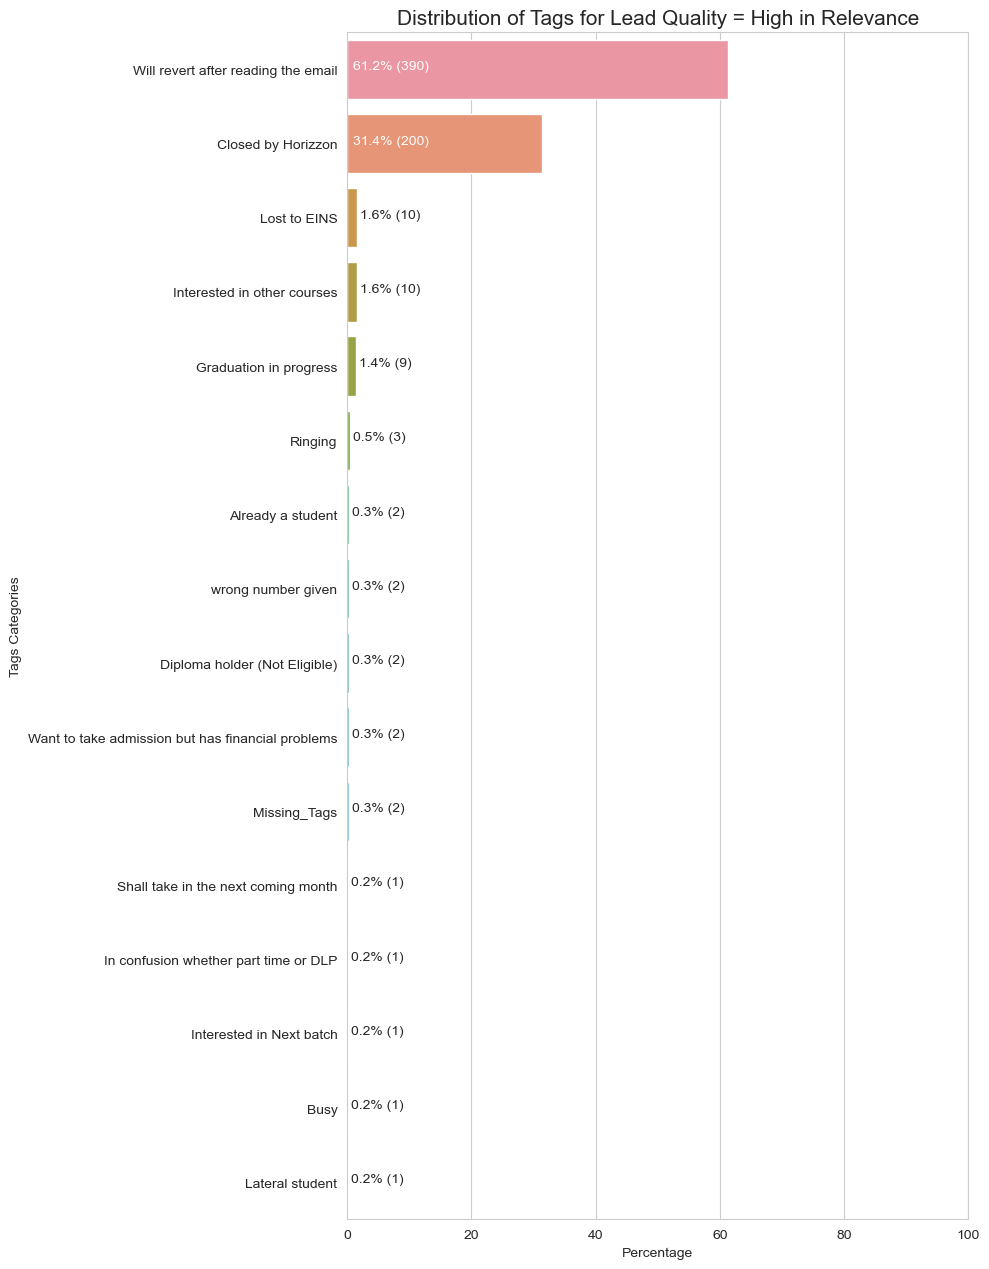

In [44]:
distribution_category_col = 'Tags' 
primary_category_col = 'Lead Quality' 

Multi_plot_distributions(df, primary_category_col, distribution_category_col)

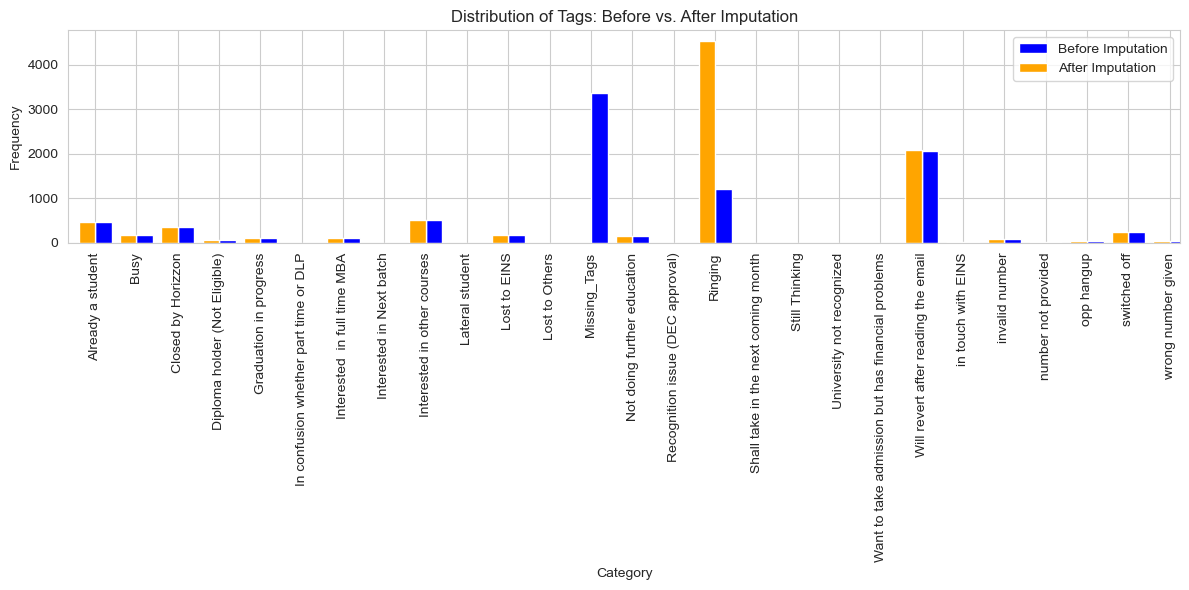

In [45]:
distribution_category_col = 'Tags' 
primary_category_col = 'Lead Quality' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

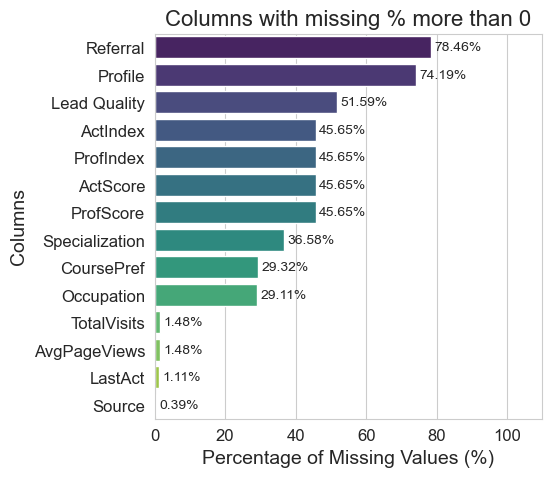

Number of non missing data columns =  23

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'Country', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  14

List of all columns with missing data =  ['Referral', 'Profile', 'Lead Quality', 'ActIndex', 'ProfIndex', 'ActScore', 'ProfScore', 'Specialization', 'CoursePref', 'Occupation', 'TotalVisits', 'AvgPageViews', 'LastAct', 'Source']



In [46]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

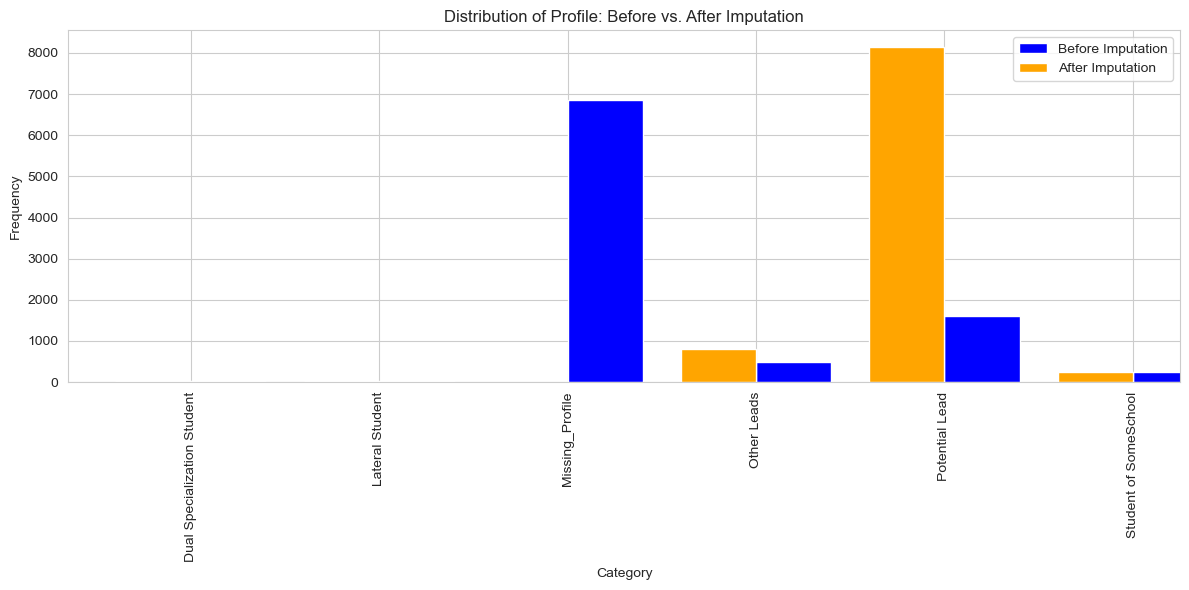

In [47]:
distribution_category_col = 'Profile' 
primary_category_col = 'ProfScore' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

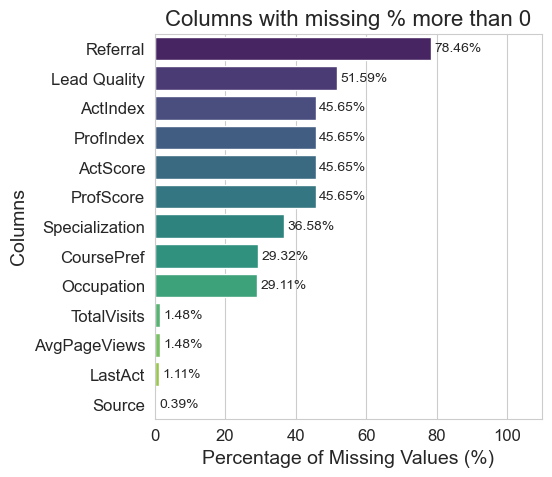

Number of non missing data columns =  24

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'Country', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  13

List of all columns with missing data =  ['Referral', 'Lead Quality', 'ActIndex', 'ProfIndex', 'ActScore', 'ProfScore', 'Specialization', 'CoursePref', 'Occupation', 'TotalVisits', 'AvgPageViews', 'LastAct', 'Source']



In [48]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

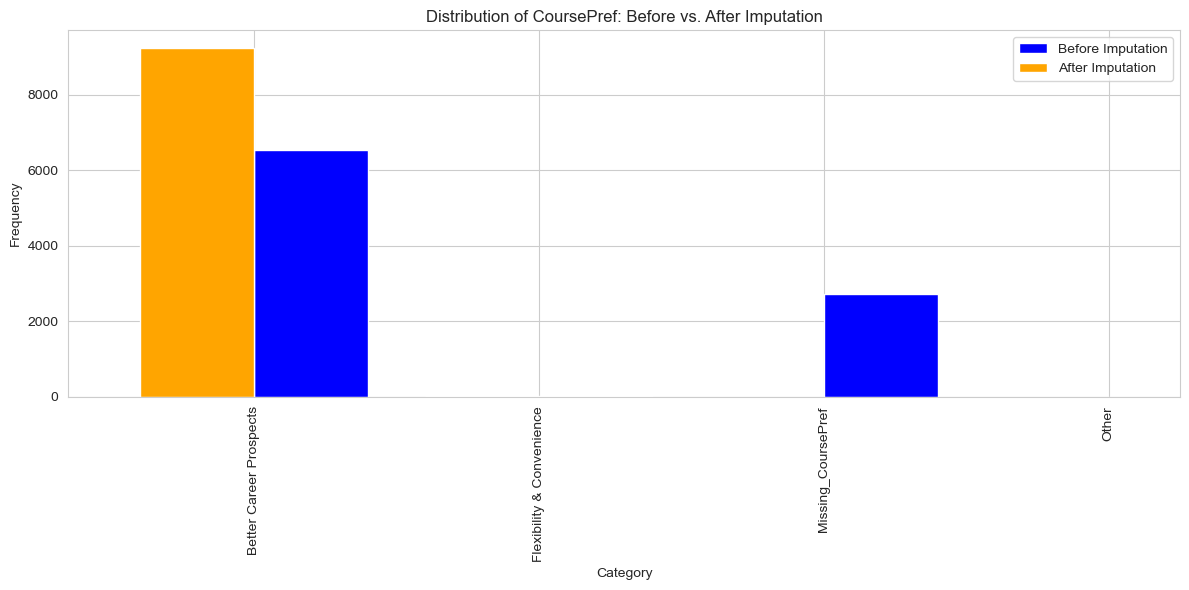

In [49]:
distribution_category_col = 'CoursePref' 
primary_category_col = 'WantsUpdates' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

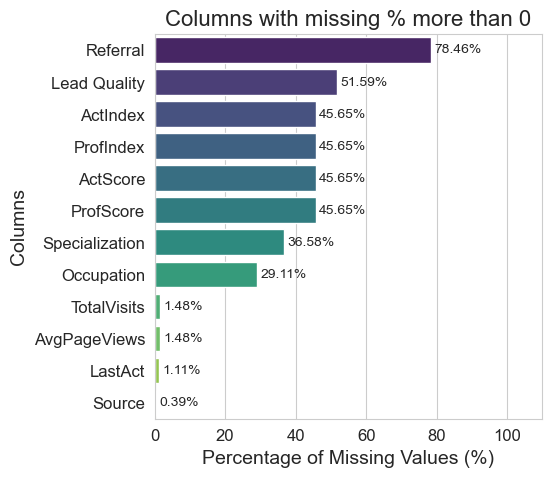

Number of non missing data columns =  25

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'Country', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  12

List of all columns with missing data =  ['Referral', 'Lead Quality', 'ActIndex', 'ProfIndex', 'ActScore', 'ProfScore', 'Specialization', 'Occupation', 'TotalVisits', 'AvgPageViews', 'LastAct', 'Source']



In [50]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

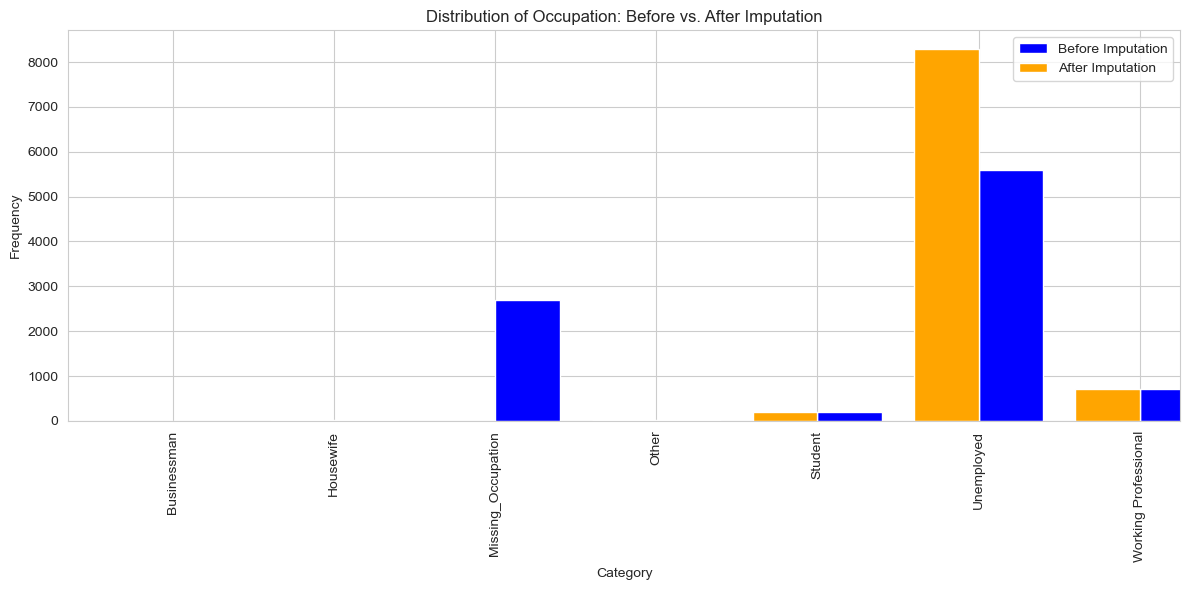

In [51]:
distribution_category_col = 'Occupation' 
primary_category_col = 'Specialization' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

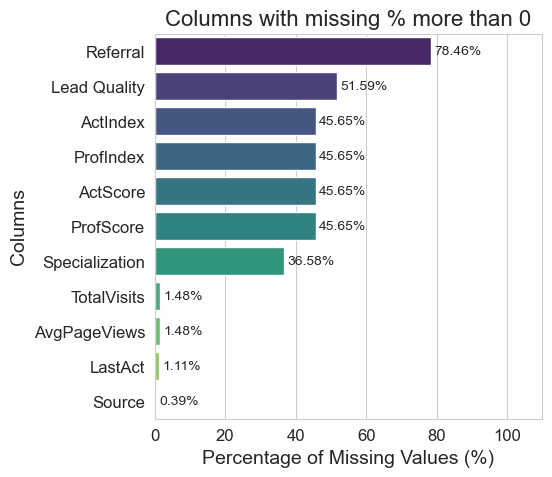

Number of non missing data columns =  26

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'Country', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  11

List of all columns with missing data =  ['Referral', 'Lead Quality', 'ActIndex', 'ProfIndex', 'ActScore', 'ProfScore', 'Specialization', 'TotalVisits', 'AvgPageViews', 'LastAct', 'Source']



In [52]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

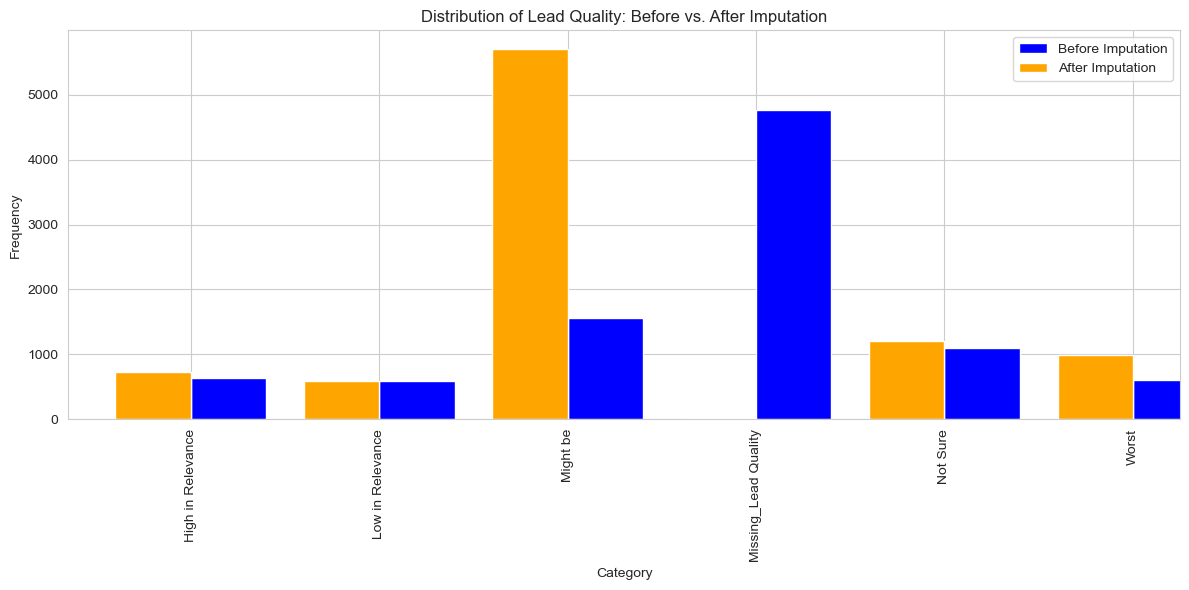

In [54]:
distribution_category_col = 'Lead Quality' 
primary_category_col = 'AvgPageViews' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

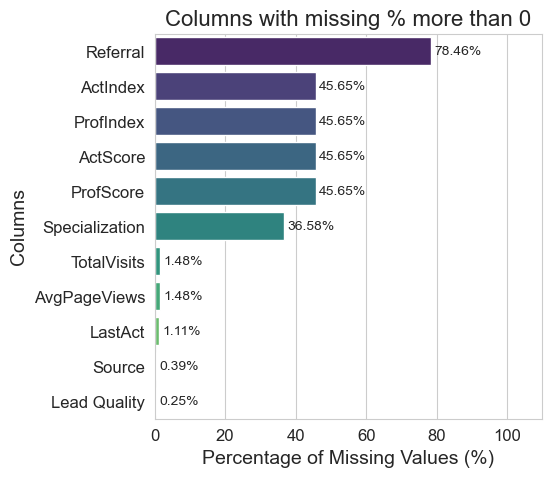

Number of non missing data columns =  26

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'Country', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  11

List of all columns with missing data =  ['Referral', 'ActIndex', 'ProfIndex', 'ActScore', 'ProfScore', 'Specialization', 'TotalVisits', 'AvgPageViews', 'LastAct', 'Source', 'Lead Quality']



In [55]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

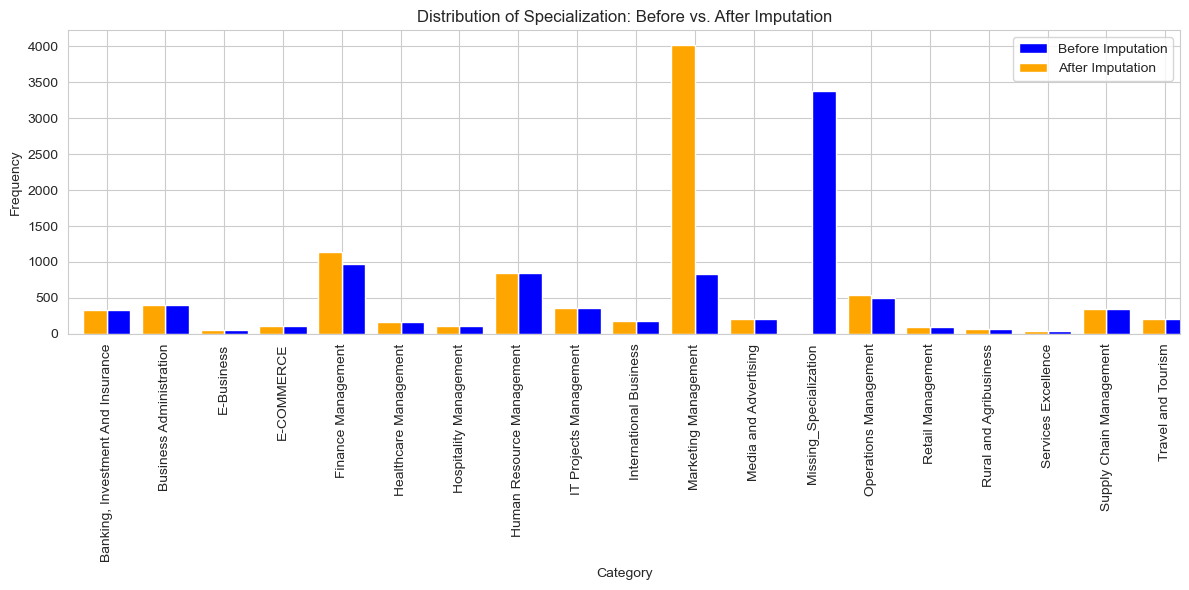

In [56]:
distribution_category_col = 'Specialization' 
primary_category_col = 'City' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

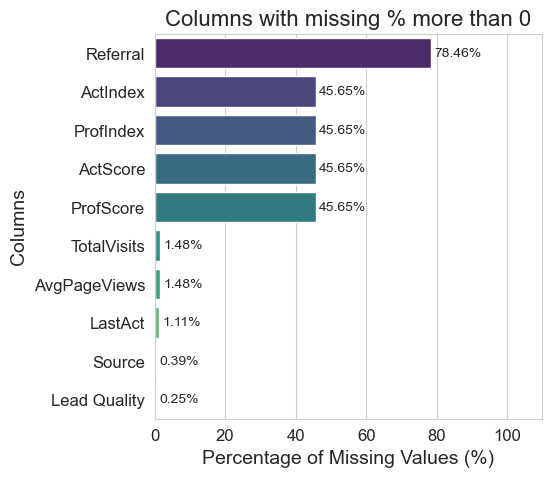

Number of non missing data columns =  27

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'Country', 'Specialization', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  10

List of all columns with missing data =  ['Referral', 'ActIndex', 'ProfIndex', 'ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'LastAct', 'Source', 'Lead Quality']



In [57]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

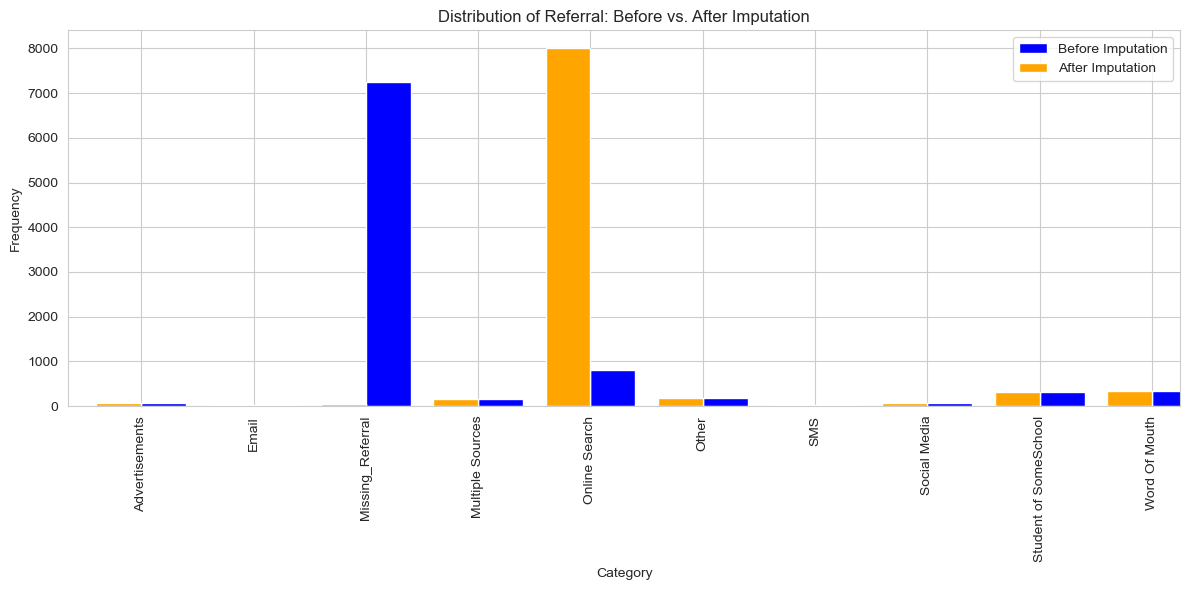

In [58]:
distribution_category_col = 'Referral' 
primary_category_col = 'Origin' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

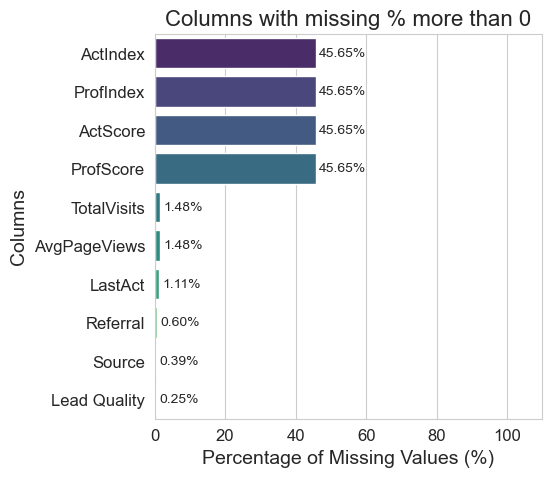

Number of non missing data columns =  27

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'Country', 'Specialization', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  10

List of all columns with missing data =  ['ActIndex', 'ProfIndex', 'ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'LastAct', 'Referral', 'Source', 'Lead Quality']



In [59]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

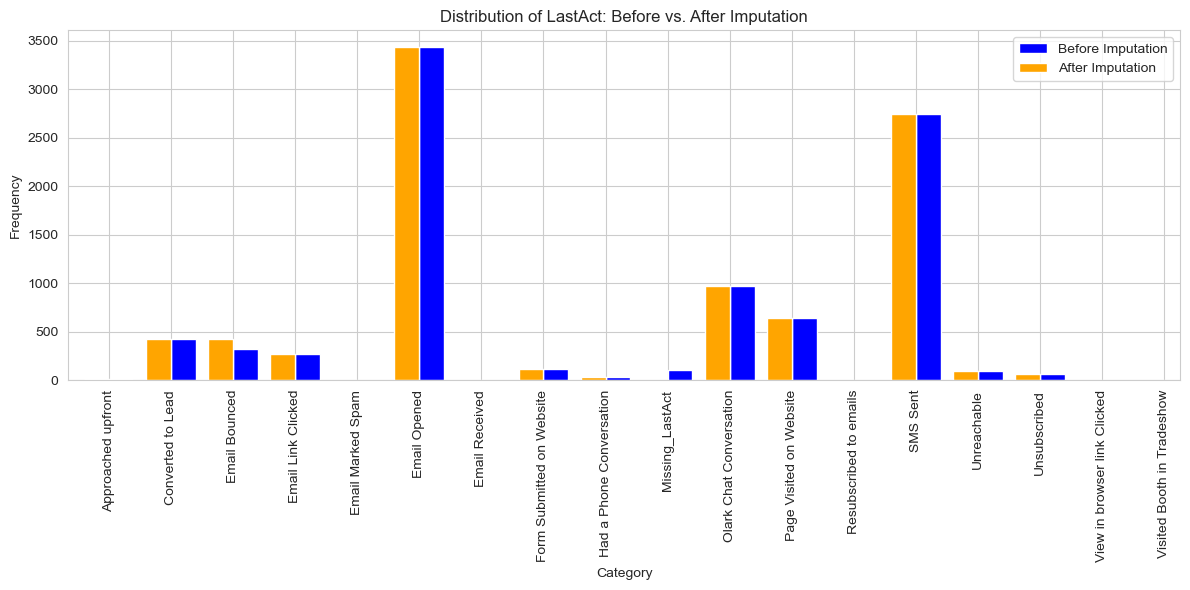

In [61]:
distribution_category_col = 'LastAct' 
primary_category_col = 'AvgPageViews' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

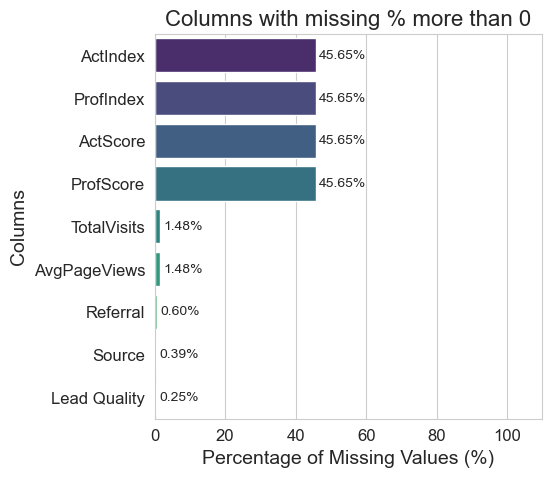

Number of non missing data columns =  28

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'LastAct', 'Country', 'Specialization', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  9

List of all columns with missing data =  ['ActIndex', 'ProfIndex', 'ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'Referral', 'Source', 'Lead Quality']



In [62]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

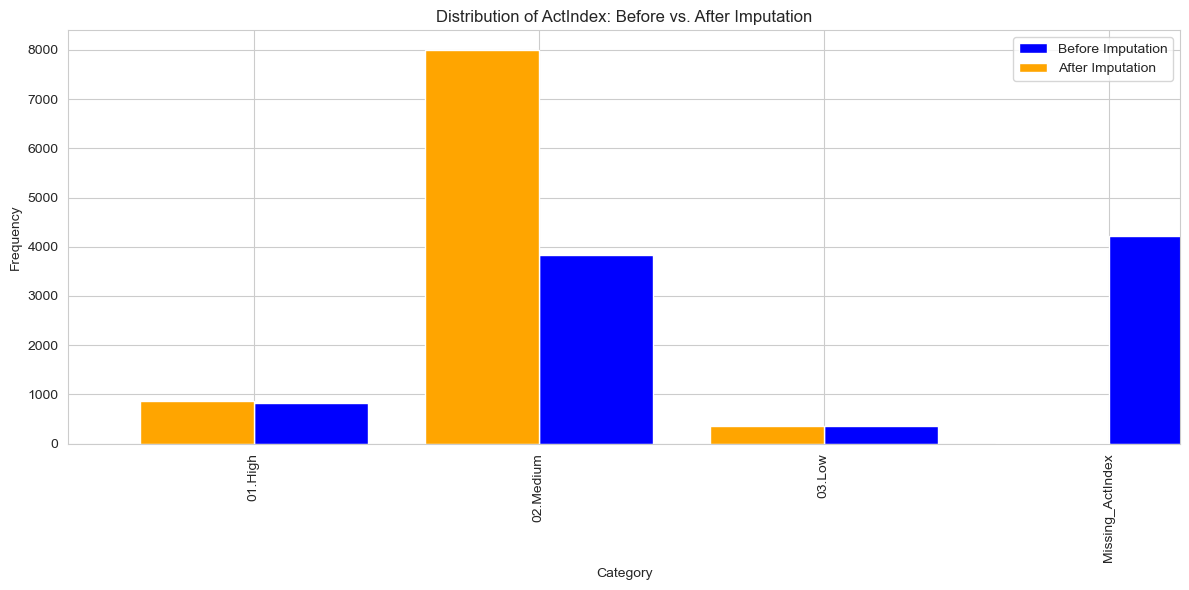

In [63]:
distribution_category_col = 'ActIndex' 
primary_category_col = 'AvgPageViews' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

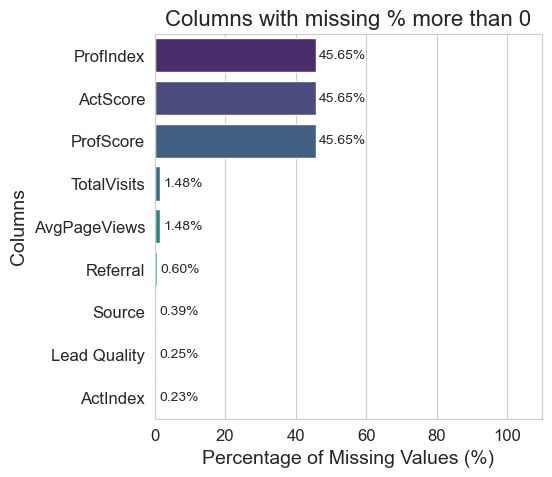

Number of non missing data columns =  28

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'LastAct', 'Country', 'Specialization', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  9

List of all columns with missing data =  ['ProfIndex', 'ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'Referral', 'Source', 'Lead Quality', 'ActIndex']



In [64]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

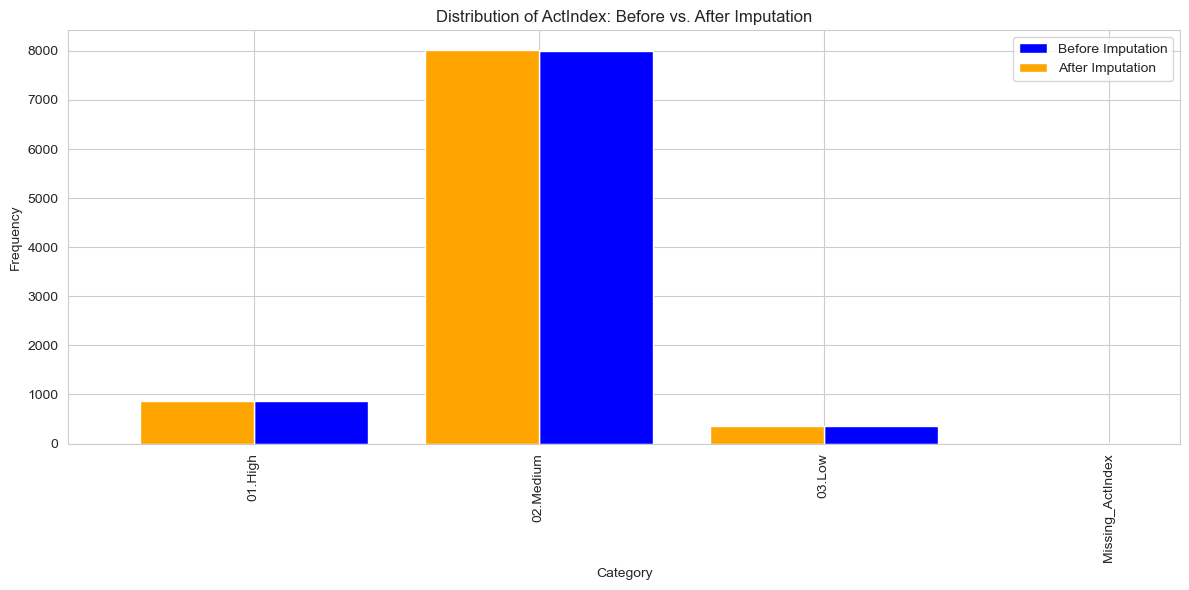

In [65]:
distribution_category_col = 'ActIndex' 
primary_category_col = 'WebsiteTime' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

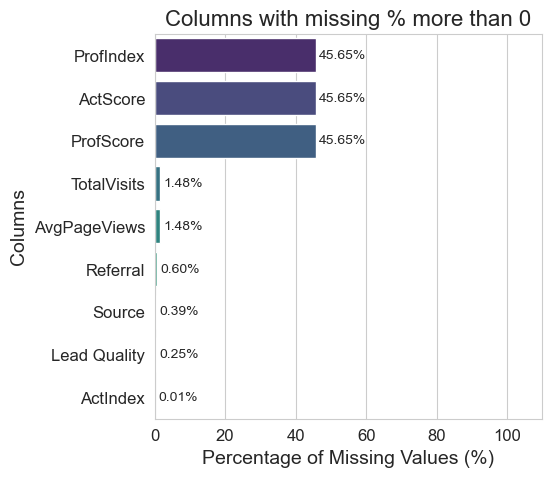

Number of non missing data columns =  28

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'LastAct', 'Country', 'Specialization', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  9

List of all columns with missing data =  ['ProfIndex', 'ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'Referral', 'Source', 'Lead Quality', 'ActIndex']



In [66]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

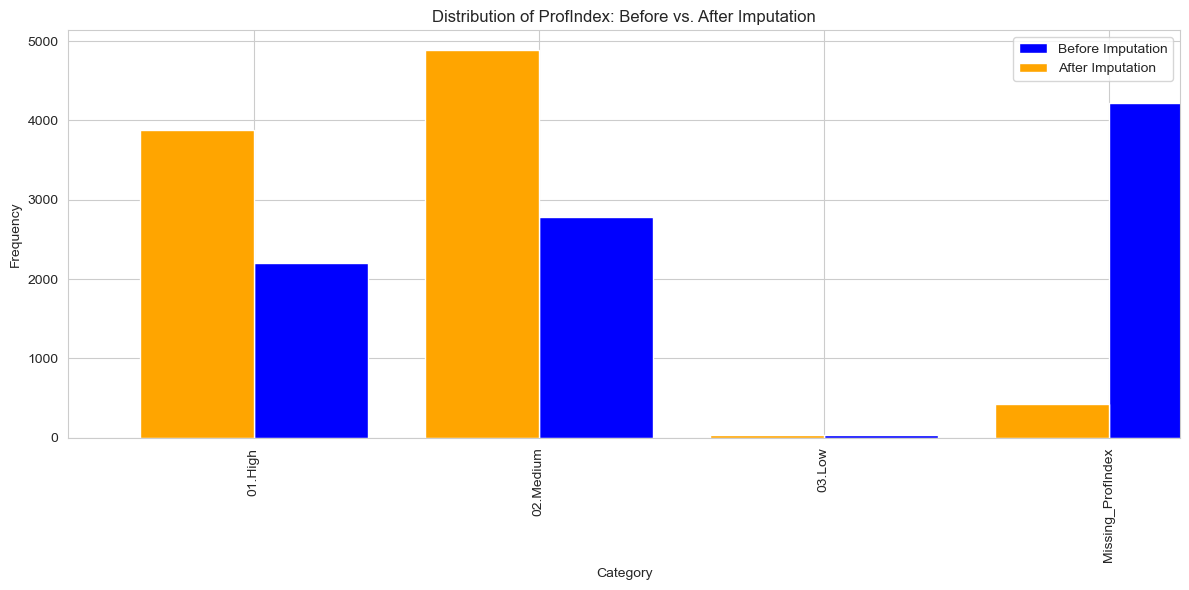

In [67]:
distribution_category_col = 'ProfIndex' 
primary_category_col = 'WebsiteTime' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

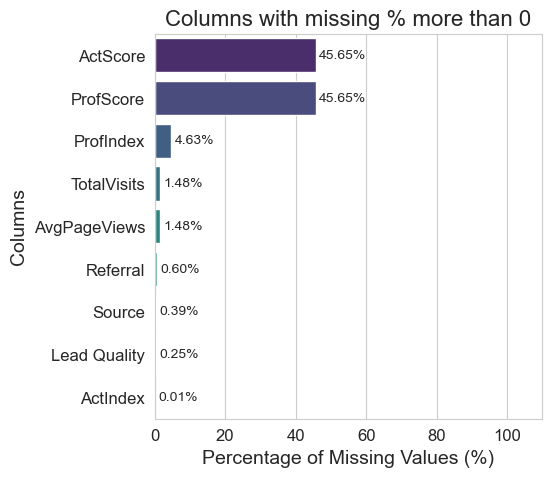

Number of non missing data columns =  28

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'LastAct', 'Country', 'Specialization', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  9

List of all columns with missing data =  ['ActScore', 'ProfScore', 'ProfIndex', 'TotalVisits', 'AvgPageViews', 'Referral', 'Source', 'Lead Quality', 'ActIndex']



In [68]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

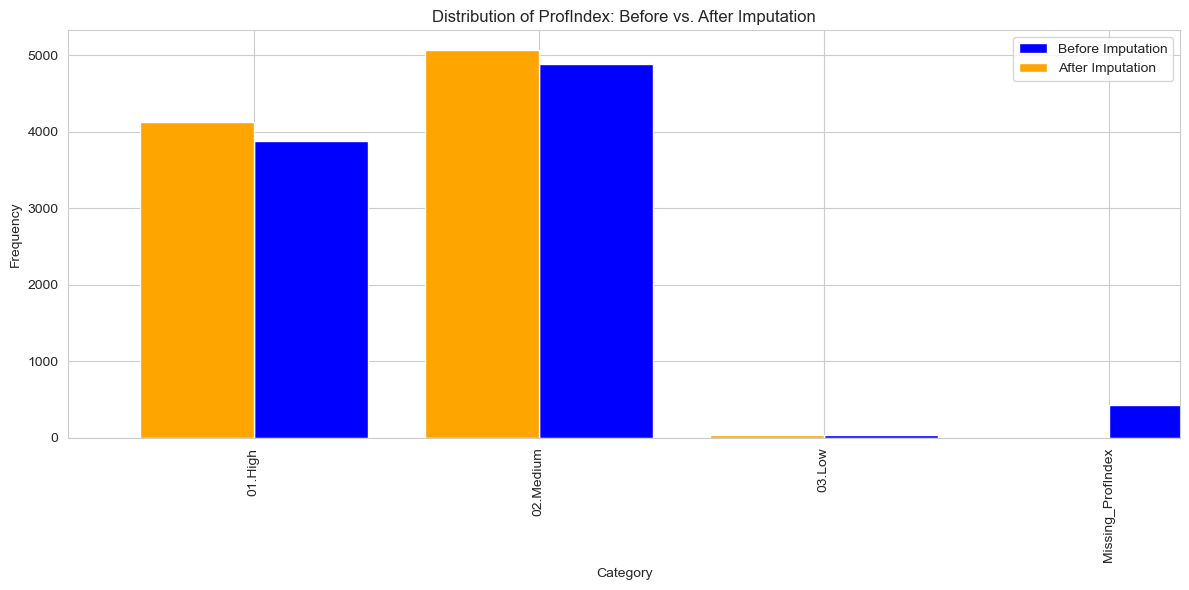

In [70]:
distribution_category_col = 'ProfIndex' 
primary_category_col = 'Specialization' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

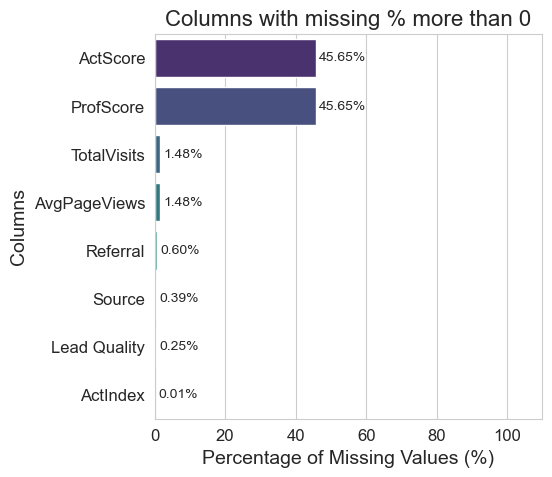

Number of non missing data columns =  29

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'LastAct', 'Country', 'Specialization', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'ProfIndex', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  8

List of all columns with missing data =  ['ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'Referral', 'Source', 'Lead Quality', 'ActIndex']



In [71]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

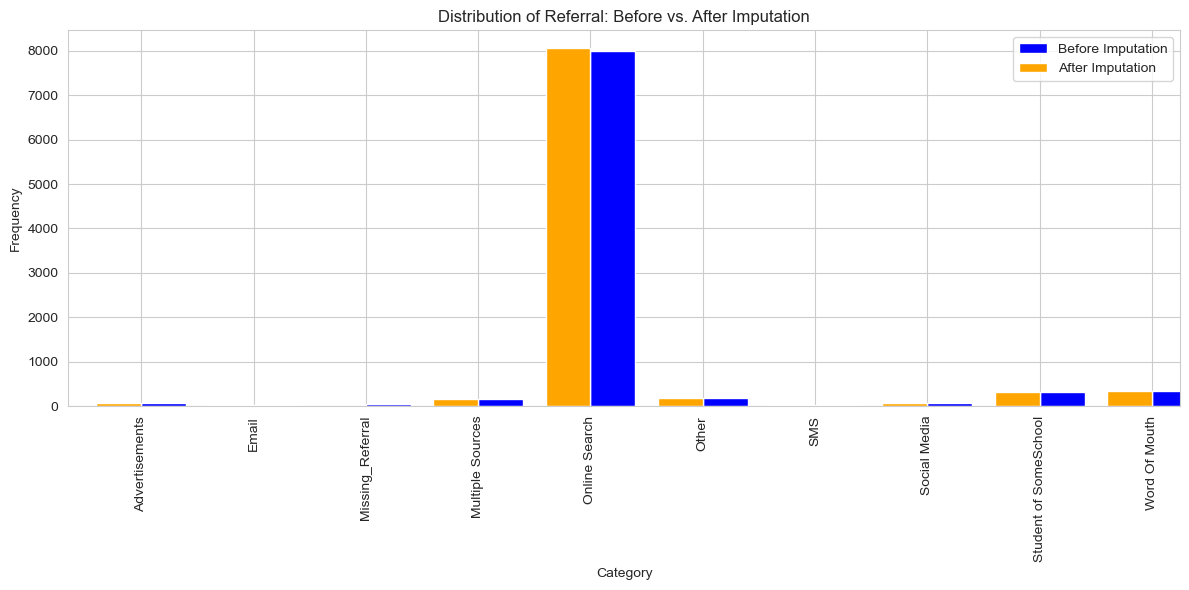

In [74]:
distribution_category_col = 'Referral' 
primary_category_col = 'Source' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

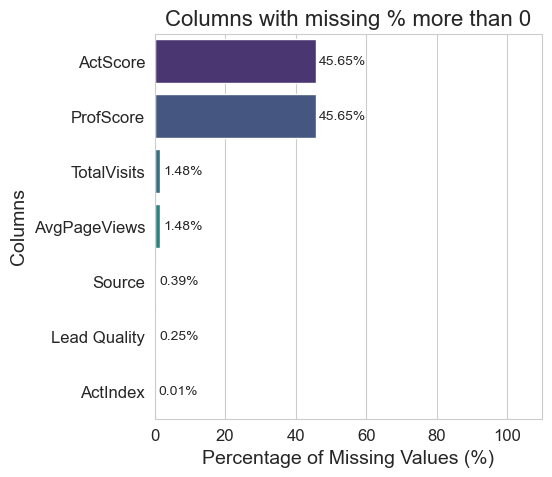

Number of non missing data columns =  30

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'LastAct', 'Country', 'Specialization', 'Referral', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'ProfIndex', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  7

List of all columns with missing data =  ['ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'Source', 'Lead Quality', 'ActIndex']



In [75]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

In [76]:
l1 =['ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'Source', 'Lead Quality', 'ActIndex']
df[l1].head()

,ActScore,ProfScore,TotalVisits,AvgPageViews,Source,Lead Quality,ActIndex
0,15.0,15.0,0.0,0.0,Olark Chat,Low in Relevance,02.Medium
1,15.0,15.0,5.0,2.5,Organic Search,Might be,02.Medium
2,14.0,20.0,2.0,2.0,Direct Traffic,Might be,02.Medium
3,13.0,17.0,1.0,1.0,Direct Traffic,Not Sure,02.Medium
4,15.0,18.0,2.0,1.0,Google,Might be,02.Medium


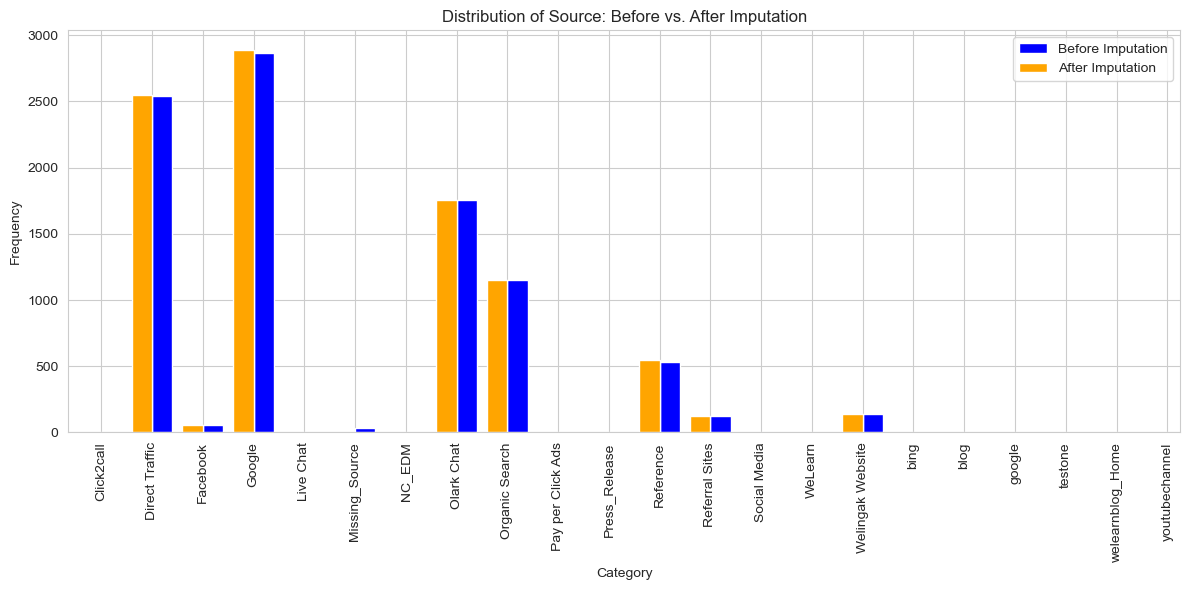

In [77]:
distribution_category_col = 'Source' 
primary_category_col = 'Lead Quality' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

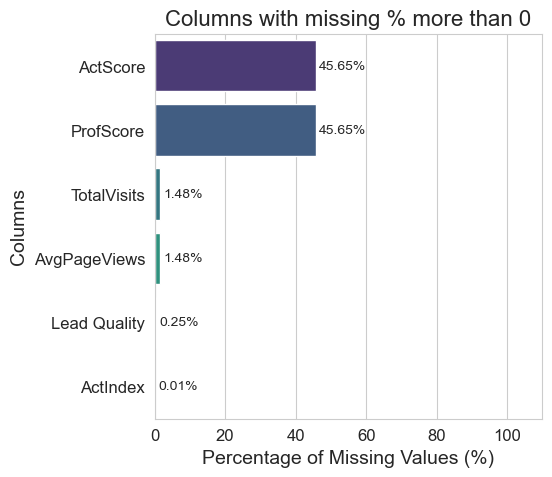

Number of non missing data columns =  31

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'Source', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'LastAct', 'Country', 'Specialization', 'Referral', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'ProfIndex', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  6

List of all columns with missing data =  ['ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'Lead Quality', 'ActIndex']



In [78]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

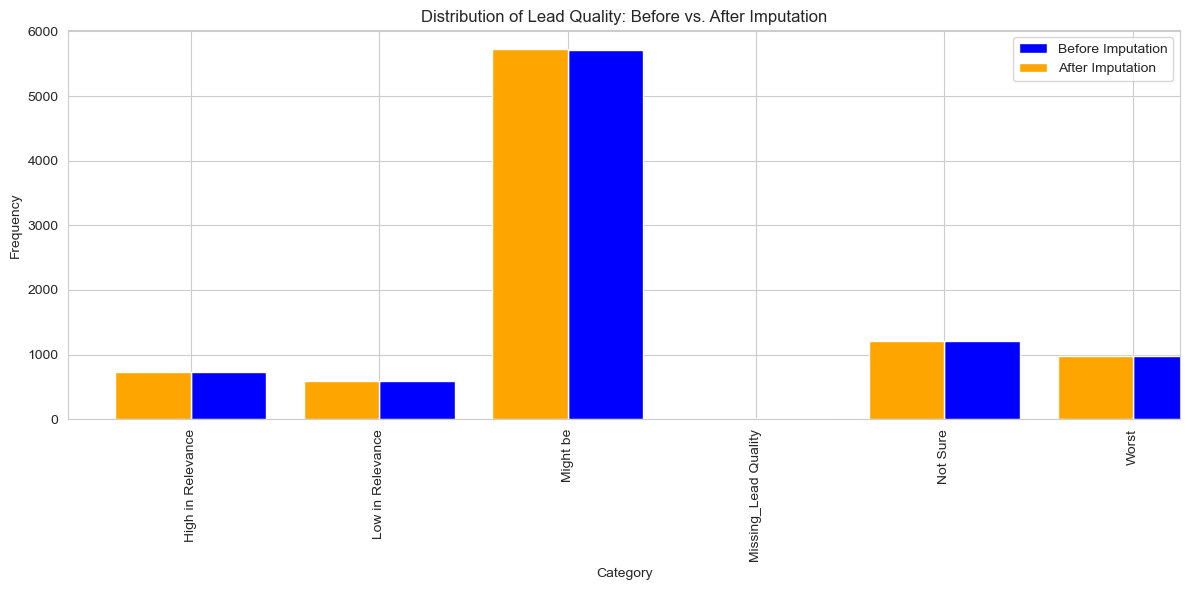

In [79]:
distribution_category_col = 'Lead Quality'
primary_category_col =   'ActIndex' 
df = impute_and_visualize(df, primary_category_col, distribution_category_col)

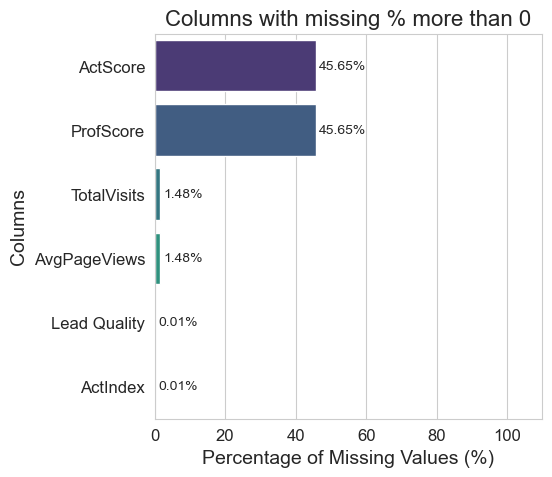

Number of non missing data columns =  31

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'Source', 'DontEmail', 'DontCall', 'Converted', 'WebsiteTime', 'LastAct', 'Country', 'Specialization', 'Referral', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'ProfIndex', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  6

List of all columns with missing data =  ['ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'Lead Quality', 'ActIndex']



In [80]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

In [82]:
l1 = ['ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews', 'Lead Quality', 'ActIndex']

df[l1].head()

,ActScore,ProfScore,TotalVisits,AvgPageViews,Lead Quality,ActIndex
0,15.0,15.0,0.0,0.0,Low in Relevance,02.Medium
1,15.0,15.0,5.0,2.5,Might be,02.Medium
2,14.0,20.0,2.0,2.0,Might be,02.Medium
3,13.0,17.0,1.0,1.0,Not Sure,02.Medium
4,15.0,18.0,2.0,1.0,Might be,02.Medium


In [81]:
def impute_with_median(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Impute the specified list of columns in the dataframe with their respective medians.
    
    Parameters:
    ----------
    df : pd.DataFrame
        The input dataframe containing the columns to be imputed.
    columns : list
        List of column names in the dataframe that need to be imputed with their medians.

    Returns:
    -------
    pd.DataFrame
        The dataframe with specified columns imputed with their medians.
    """
    df_copy = df.copy()
    for col in columns:
        if col in df_copy.columns:
            median_value = df_copy[col].median()
            df_copy[col].fillna(median_value, inplace=True)
    return df_copy


In [83]:
l2 = ['ActScore', 'ProfScore', 'TotalVisits', 'AvgPageViews']
df = impute_with_median(df,l2 )

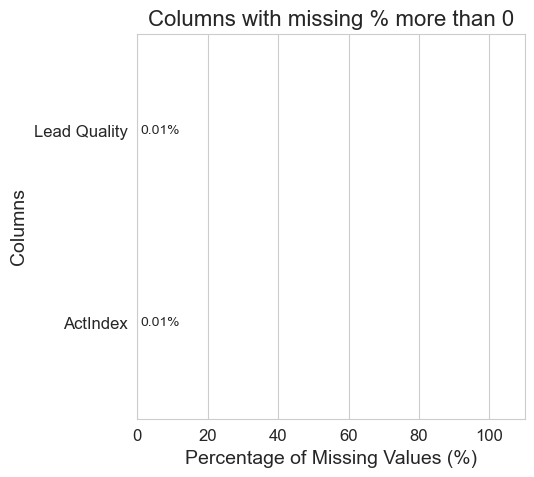

Number of non missing data columns =  35

List of all columns with non missing data =  ['ProspectID', 'LeadNum', 'Origin', 'Source', 'DontEmail', 'DontCall', 'Converted', 'TotalVisits', 'WebsiteTime', 'AvgPageViews', 'LastAct', 'Country', 'Specialization', 'Referral', 'Occupation', 'CoursePref', 'OnlineSearch', 'MagazineSub', 'NewsArticle', 'ForumVisit', 'ReadNews', 'DigitalAd', 'Recommended', 'WantsUpdates', 'Tags', 'SupplyChainInfo', 'DMInfo', 'Profile', 'City', 'ProfIndex', 'ActScore', 'ProfScore', 'PayByCheque', 'InterviewCopy', 'LastMajorAct']

Number of missing data columns =  2

List of all columns with missing data =  ['Lead Quality', 'ActIndex']



In [84]:
non_missing_count, non_missing_data_columns_names , missing_count, missing_data_columns_names = plot_missing_values(df)

In [85]:
l1 = [ 'Lead Quality', 'ActIndex']

df[l1].head()

,Lead Quality,ActIndex
0,Low in Relevance,02.Medium
1,Might be,02.Medium
2,Might be,02.Medium
3,Not Sure,02.Medium
4,Might be,02.Medium


In [87]:
def impute_with_mode(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Impute the specified list of categorical columns in the dataframe with their respective modes.
    
    Parameters:
    ----------
    df : pd.DataFrame
        The input dataframe containing the columns to be imputed.
    columns : list
        List of categorical column names in the dataframe that need to be imputed with their modes.

    Returns:
    -------
    pd.DataFrame
        The dataframe with specified categorical columns imputed with their modes.
    """
    df_copy = df.copy()
    for col in columns:
        if col in df_copy.columns:
            mode_value = df_copy[col].mode().iloc[0]
            df_copy[col].fillna(mode_value, inplace=True)
    return df_copy


In [89]:
df = impute_with_mode(df,l1)

In [90]:
#  Saving new datframe to csv 
df.to_csv('Clean_df.csv', index=False)
